In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

c:\Apps\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Apps\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Apps\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [22]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(9,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(data.shape[1], activation='sigmoid'))

    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(data.shape[1],)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

# Define the loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Define the loss function for the generator
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)


# Define the training function for the discriminator
def train_discriminator(discriminator, real_data, generator, optimizer):
    noise = tf.random.normal([real_data.shape[0], 9])
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        fake_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(fake_data, training=True)
        
        epsilon = tf.random.uniform([real_data.shape[0], 1], 0, 1)
        interpolated_data = epsilon * tf.cast(real_data, dtype=tf.float32) + (1 - epsilon) * tf.cast(fake_data, dtype=tf.float32)
        interpolated_output = discriminator(interpolated_data, training=True)
        
        gradient_norms = tf.norm(tape2.gradient(interpolated_output, interpolated_data), axis=1)
        gradient_penalty = 10 * tf.reduce_mean((gradient_norms - 1) ** 2)
        
        loss = discriminator_loss(real_output, fake_output) + gradient_penalty
    
    gradients = tape1.gradient(loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss


# Define the training function for the generator
def train_generator(generator, discriminator, optimizer):
    noise = tf.random.normal([batch_size, 9])
    with tf.GradientTape() as tape:
        fake_data = generator(noise, training=True)
        fake_output = discriminator(fake_data, training=True)
        loss = generator_loss(fake_output)
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

# Define the number of updates for the generator in each epoch
# TODO:
num_generator_updates = 5  # You can adjust this value as needed

# Define the training loop
def train(dataset, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs):
    for epoch in range(epochs):
        for real_data in dataset:
            discriminator_loss = train_discriminator(discriminator, real_data, generator, discriminator_optimizer)
        for _ in range(5):  # Update the generator multiple times FIXME:
            generator_loss = train_generator(generator, discriminator, generator_optimizer)
        print(f'Epoch {epoch+1}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}')

# Load the data
raw_data = pd.read_csv('Line C_PR.csv')
raw_data = raw_data.drop(['RING_NR', 'Advance rate (mm/min)', 'Thrust pressure (bar)'], axis=1)
raw_data = raw_data[raw_data['Penetration rate (mm/rpm)'] < 125]

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(raw_data)

# Define the batch size and number of epochs
# TODO:
batch_size = 128
epochs = 10000

# Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the optimizers
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data)).batch(batch_size)

# Train the models
train(dataset, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs)

# Generate new data
noise = tf.random.normal([1000, 9])
generated_data = generator(noise, training=False)
generated_data = scaler.inverse_transform(generated_data)
generated_data = pd.DataFrame(generated_data, columns=raw_data.columns)
generated_data.to_csv('generated_data1.csv', index=False)

c:\Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") a

Epoch 1, Discriminator Loss: 2.1399331092834473, Generator Loss: 0.16605550050735474
Epoch 2, Discriminator Loss: 0.3282157778739929, Generator Loss: 0.23533129692077637
Epoch 3, Discriminator Loss: 0.005648985505104065, Generator Loss: 0.2747008800506592
Epoch 4, Discriminator Loss: -0.08230844140052795, Generator Loss: 0.32522955536842346
Epoch 5, Discriminator Loss: -0.11007679998874664, Generator Loss: 0.36103808879852295
Epoch 6, Discriminator Loss: -0.1511934995651245, Generator Loss: 0.4013218879699707
Epoch 7, Discriminator Loss: -0.24145403504371643, Generator Loss: 0.4109465479850769
Epoch 8, Discriminator Loss: -0.2737707495689392, Generator Loss: 0.412179559469223
Epoch 9, Discriminator Loss: -0.3169197738170624, Generator Loss: 0.41833221912384033
Epoch 10, Discriminator Loss: -0.2398562878370285, Generator Loss: 0.40444284677505493
Epoch 11, Discriminator Loss: -0.24374805390834808, Generator Loss: 0.35092830657958984
Epoch 12, Discriminator Loss: -0.2303657829761505, Gen

In [46]:
raw_data

Torque cutting wheel (MN*m)  Pressure force cutting wheel (kN)  \
0                        7.014017                       10547.115990   
1                        6.004700                       12134.245130   
2                        7.205679                       16230.916050   
3                        5.725779                       10753.376010   
4                        6.853529                       10765.890920   
...                           ...                                ...   
1261                     7.257339                        5544.577299   
1262                     6.662276                        4564.721790   
1263                     4.541290                        3704.344086   
1264                     2.340455                        1869.296364   
1265                     4.328590                        1925.305556   

      Thrust force (kN)  Torque screw (kN*m)  \
0          33241.118650            14.234993   
1          33793.731070            11.235935   
2          33412.537290             9.581091   
3          27921.046540             7.848301   
4          24673.746690             9.659680   
...                 ...                  ...   
1261       25424.483370            30.211409   
1262       19276.980540            36.147996   
1263       18043.089610            32.982151   
1264       14090.470910            27.211764   
1265        9355.773504            37.244786   

      Cutting wheel speed of rotation (rpm)  Earth pressure (bar)  \
0                                  1.460061              2.718894   
1                                  1.678613              2.206482   
2                                  1.594882              2.305811   
3                                  1.860316              2.254039   
4                                  1.957915              2.085312   
...                                     ...                   ...   
1261                               0.418982              1.408001   
1262                               0.392665              1.159327   
1263                               0.340000              0.937642   
1264                               0.273618              0.209894   
1265                               0.322628              0.139673   

      Pressure foam lance (bar)  Excavated material flow (t/h)  \
0                      0.399647                      92.254441   
1                      0.280003                      67.296019   
2                      0.254414                      59.714828   
3                      1.255566                      59.009183   
4                      1.182521                      82.467050   
...                         ...                            ...   
1261                   1.040949                     128.440313   
1262                   0.909484                     141.256809   
1263                   0.788396                     129.697133   
1264                   0.433864                     176.778182   
1265                   1.097382                     129.974359   

      Penetration rate (mm/rpm)  
0                      6.471854  
1                      4.440113  
2                      4.490550  
3                      3.154584  
4                      4.340012  
...                         ...  
1261                  38.989411  
1262                  43.677321  
1263                  48.938855  
1264                  69.627180  
1265                  65.151677  

[1262 rows x 9 columns]

In [47]:
generated_data

Torque cutting wheel (MN*m)  Pressure force cutting wheel (kN)  \
0                       7.840395                        6425.278148   
1                       7.453697                        8928.490270   
2                       7.557973                       12980.071704   
3                       5.933755                        6934.256487   
4                       7.175441                        7014.818598   
..                           ...                                ...   
995                     7.656529                       11656.690784   
996                     6.927866                        9149.674941   
997                     7.772577                        7228.490417   
998                     7.563686                       11196.257724   
999                     7.308241                        9802.720891   

     Thrust force (kN)  Torque screw (kN*m)  \
0         23765.861446            14.785214   
1         27143.535655             9.302853   
2         40126.870545             5.916601   
3         35725.660269             6.049071   
4         35333.237421            31.153793   
..                 ...                  ...   
995       29243.541656            16.257976   
996       41984.212472             5.300144   
997       21315.275933            34.889888   
998       28006.645034             6.930390   
999       33441.065304            13.843756   

     Cutting wheel speed of rotation (rpm)  Earth pressure (bar)  \
0                                 1.824227              2.346178   
1                                 2.011424              2.315514   
2                                 1.665777              2.878049   
3                                 2.130678              2.080173   
4                                 0.254694              1.712420   
..                                     ...                   ...   
995                               0.254248              1.484915   
996                               1.855381              2.739072   
997                               1.994314              2.171273   
998                               1.876779              2.147265   
999                               2.061770              2.111659   

     Pressure foam lance (bar)  Excavated material flow (t/h)  \
0                     1.736620                     116.111045   
1                     2.771336                      79.080015   
2                     1.988293                      96.547063   
3                     2.337234                      89.170121   
4                     1.076604                     113.608440   
..                         ...                            ...   
995                   0.772291                      74.511328   
996                   1.878800                      84.668614   
997                   1.829721                     168.525770   
998                   2.114875                      86.485596   
999                   1.782824                     115.045381   

     Penetration rate (mm/rpm)  
0                     0.962117  
1                     0.962406  
2                     0.962036  
3                     0.963040  
4                     0.961905  
..                         ...  
995                   0.961896  
996                   0.963523  
997                   0.963463  
998                   0.963584  
999                   0.962750  

[1000 rows x 9 columns]

In [38]:
# Generate new data
noise = tf.random.normal([1000, 9])
generated_data = generator(noise, training=False)
generated_data = scaler.inverse_transform(generated_data)
generated_data = pd.DataFrame(generated_data, columns=raw_data.columns)
generated_data.to_csv('generated_data1.csv', index=False)

In [44]:
generated = pd.read_csv('generated_data1.csv')
real = pd.read_csv('Line C_PR.csv')
real = real.drop(['RING_NR', 'Advance rate (mm/min)','Thrust pressure (bar)'], axis=1)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

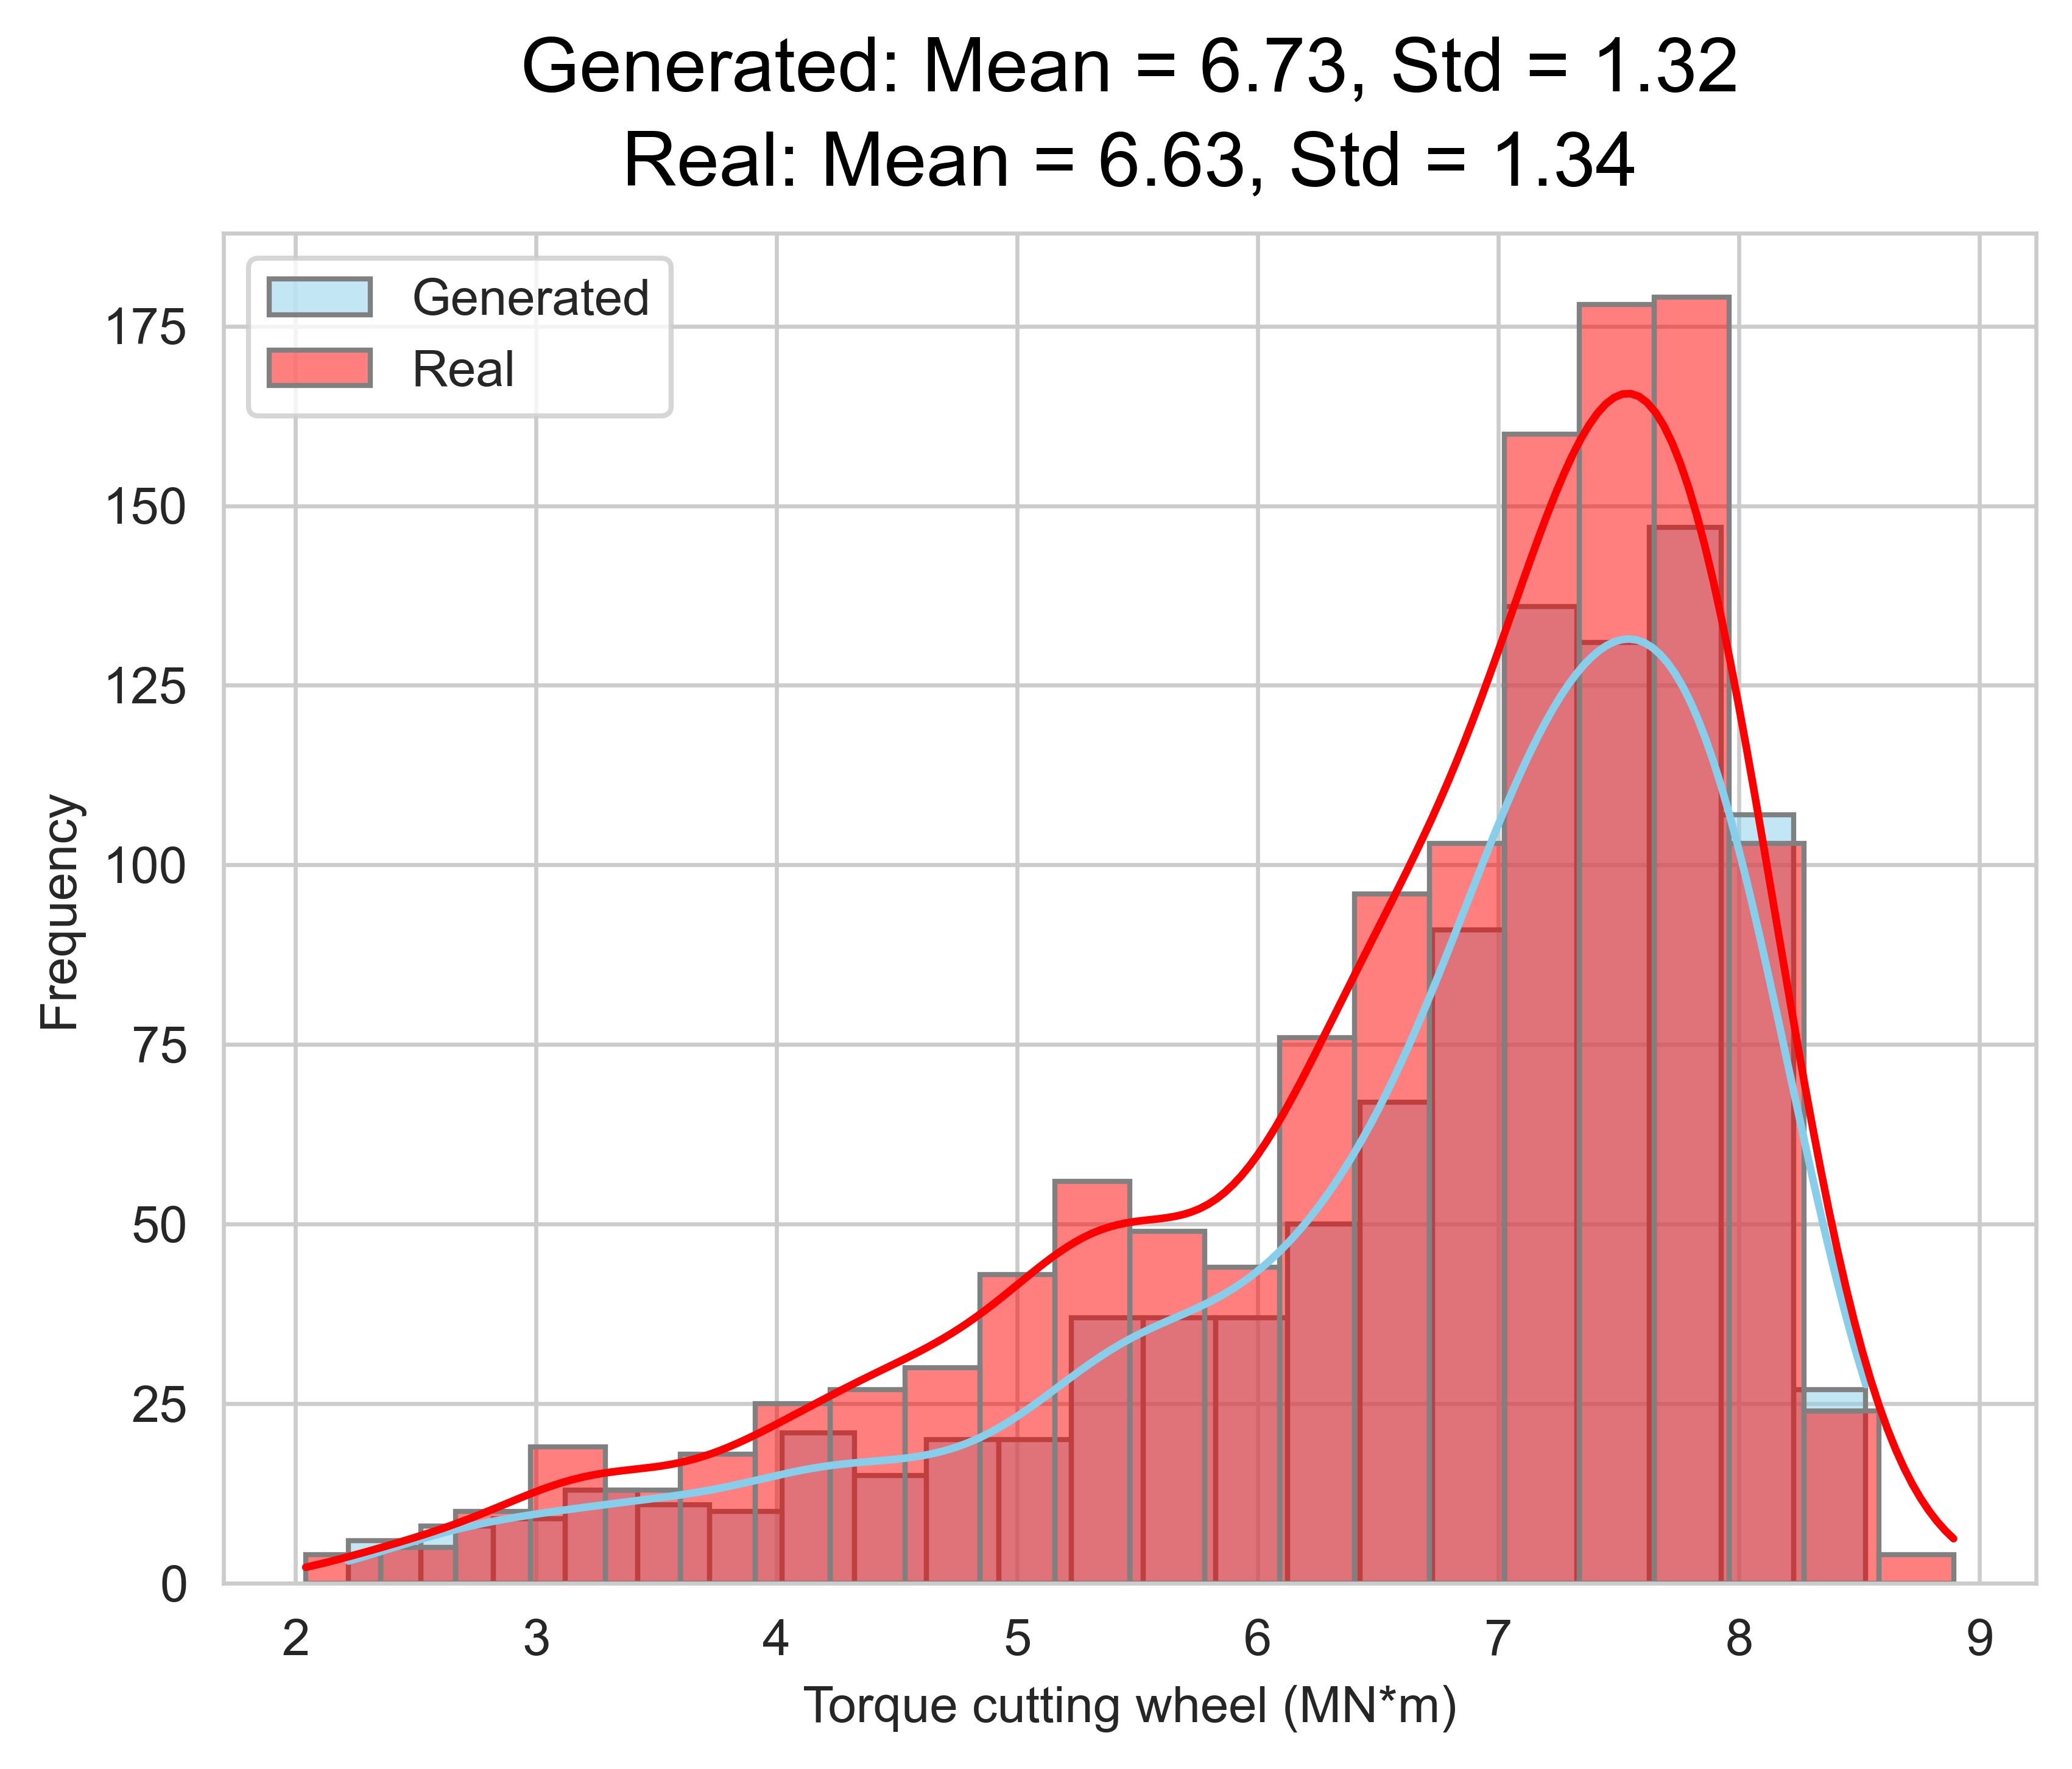

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

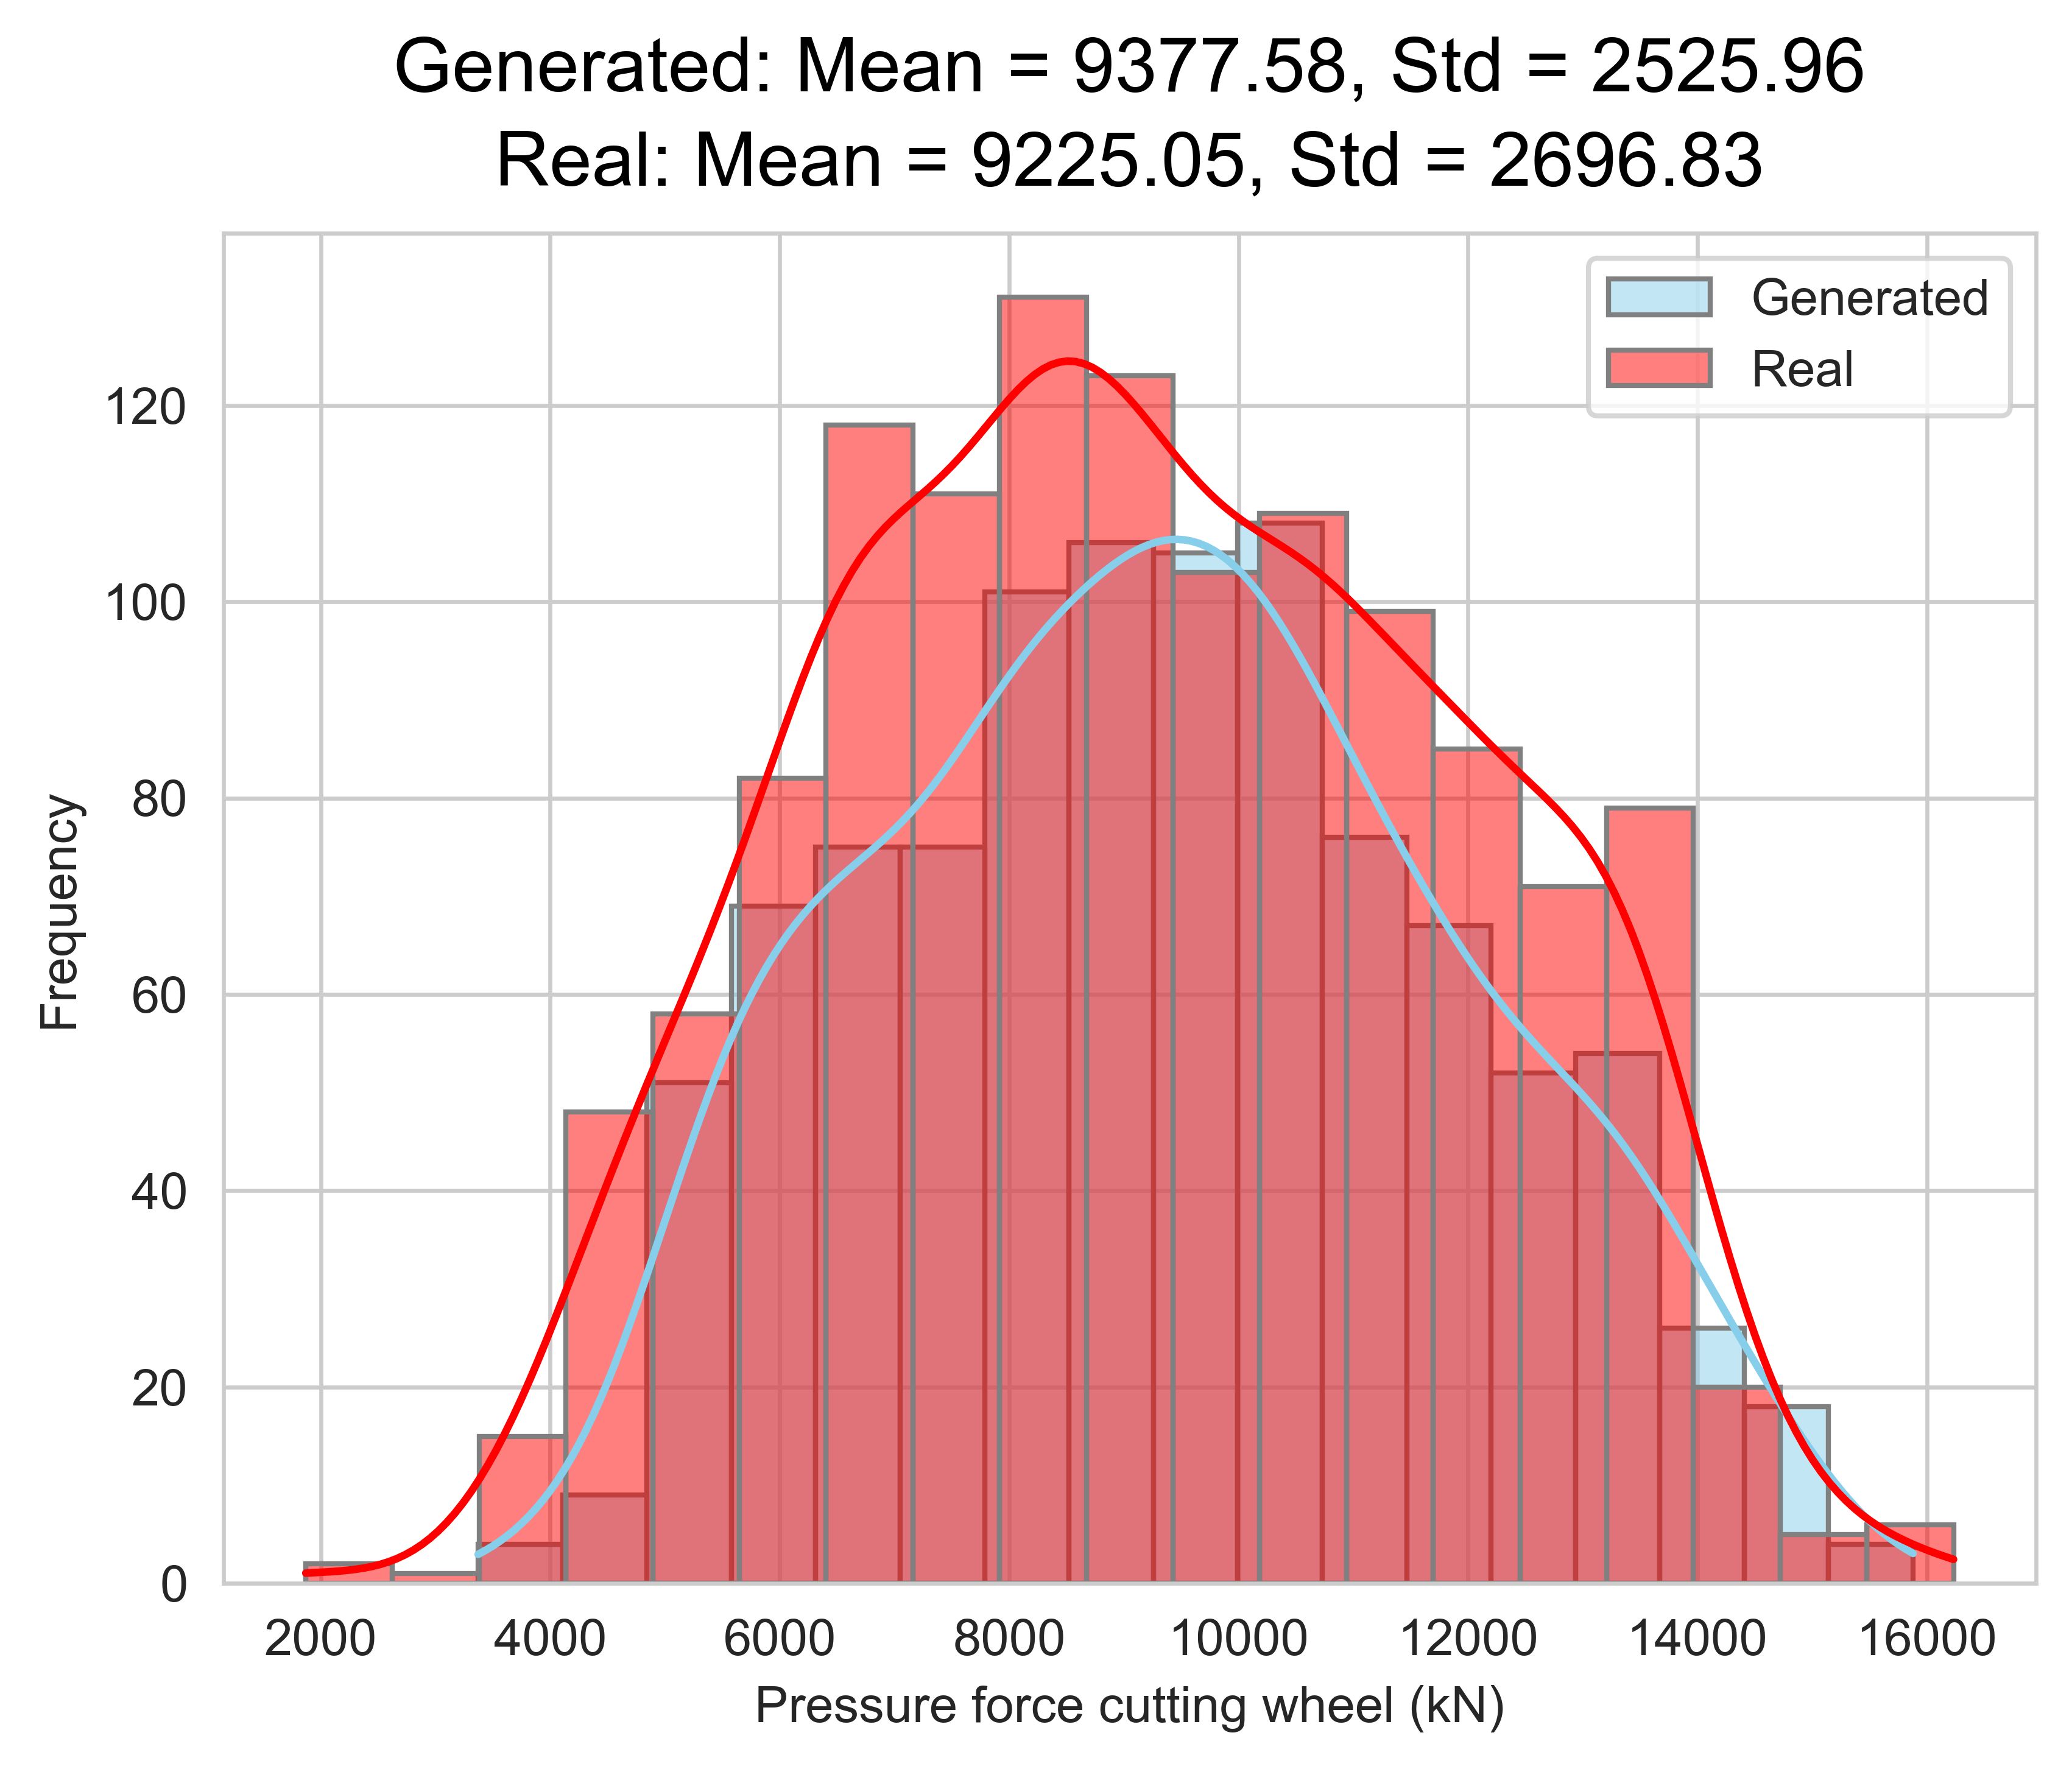

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

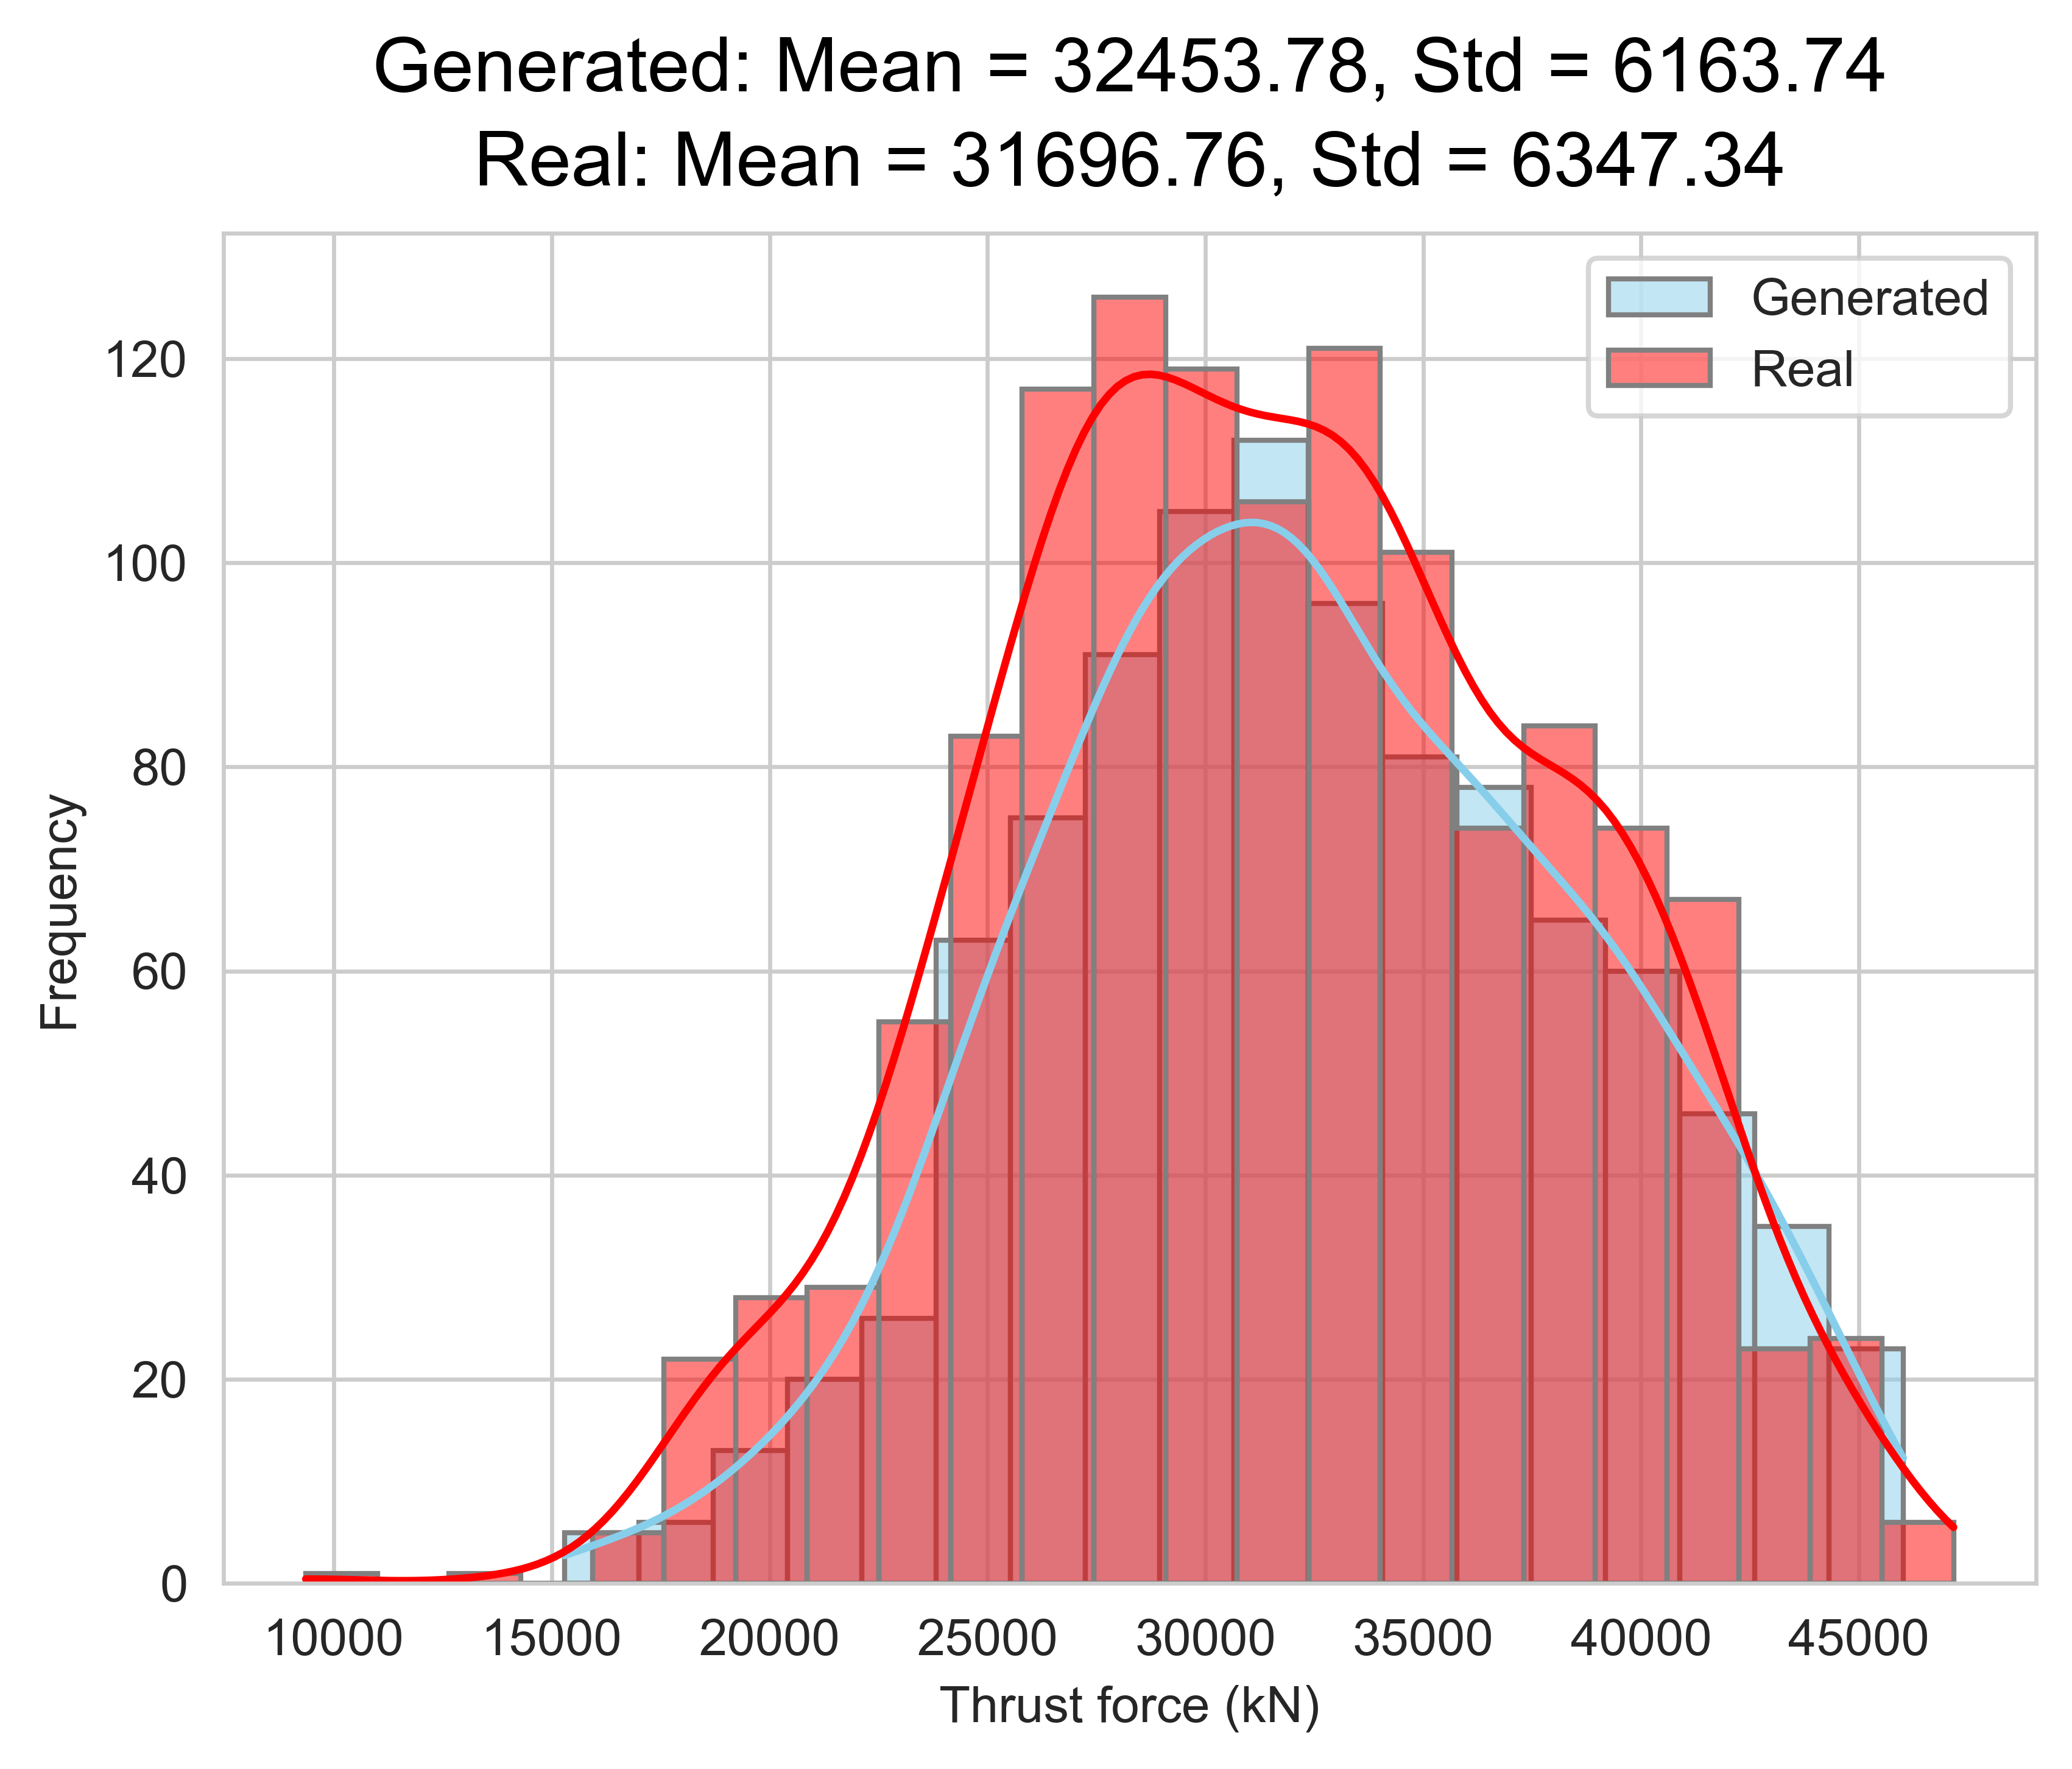

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

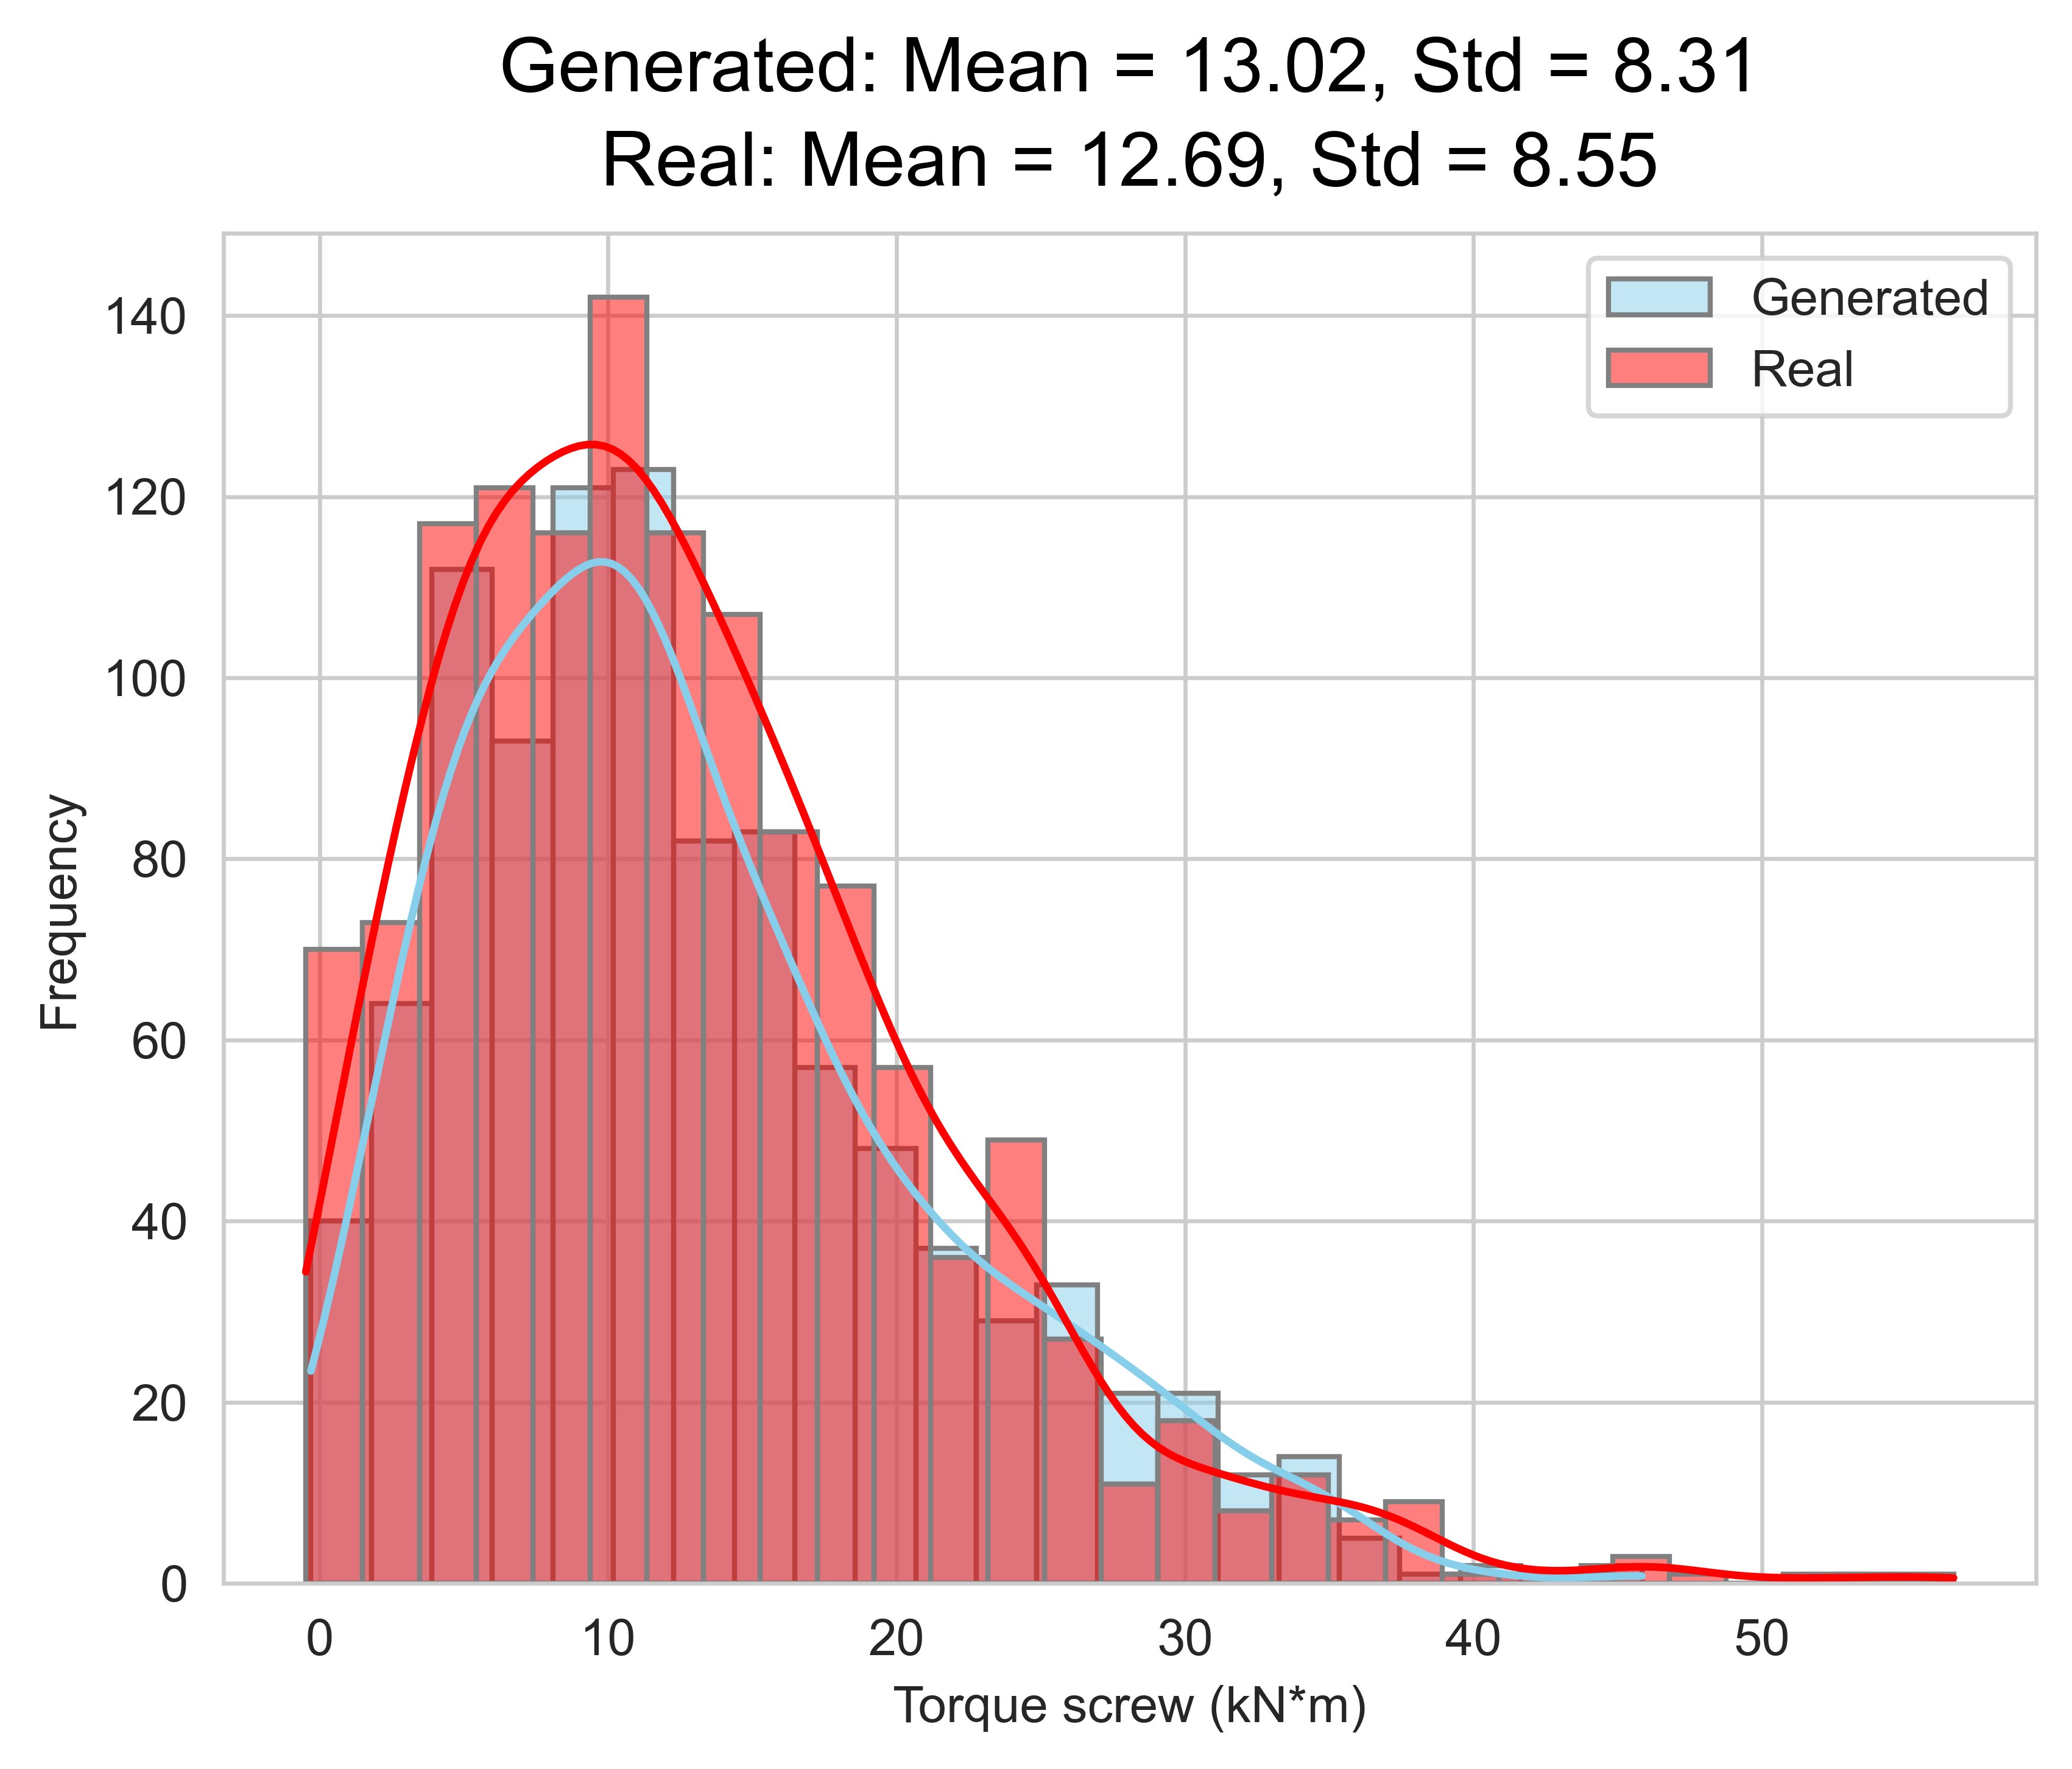

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

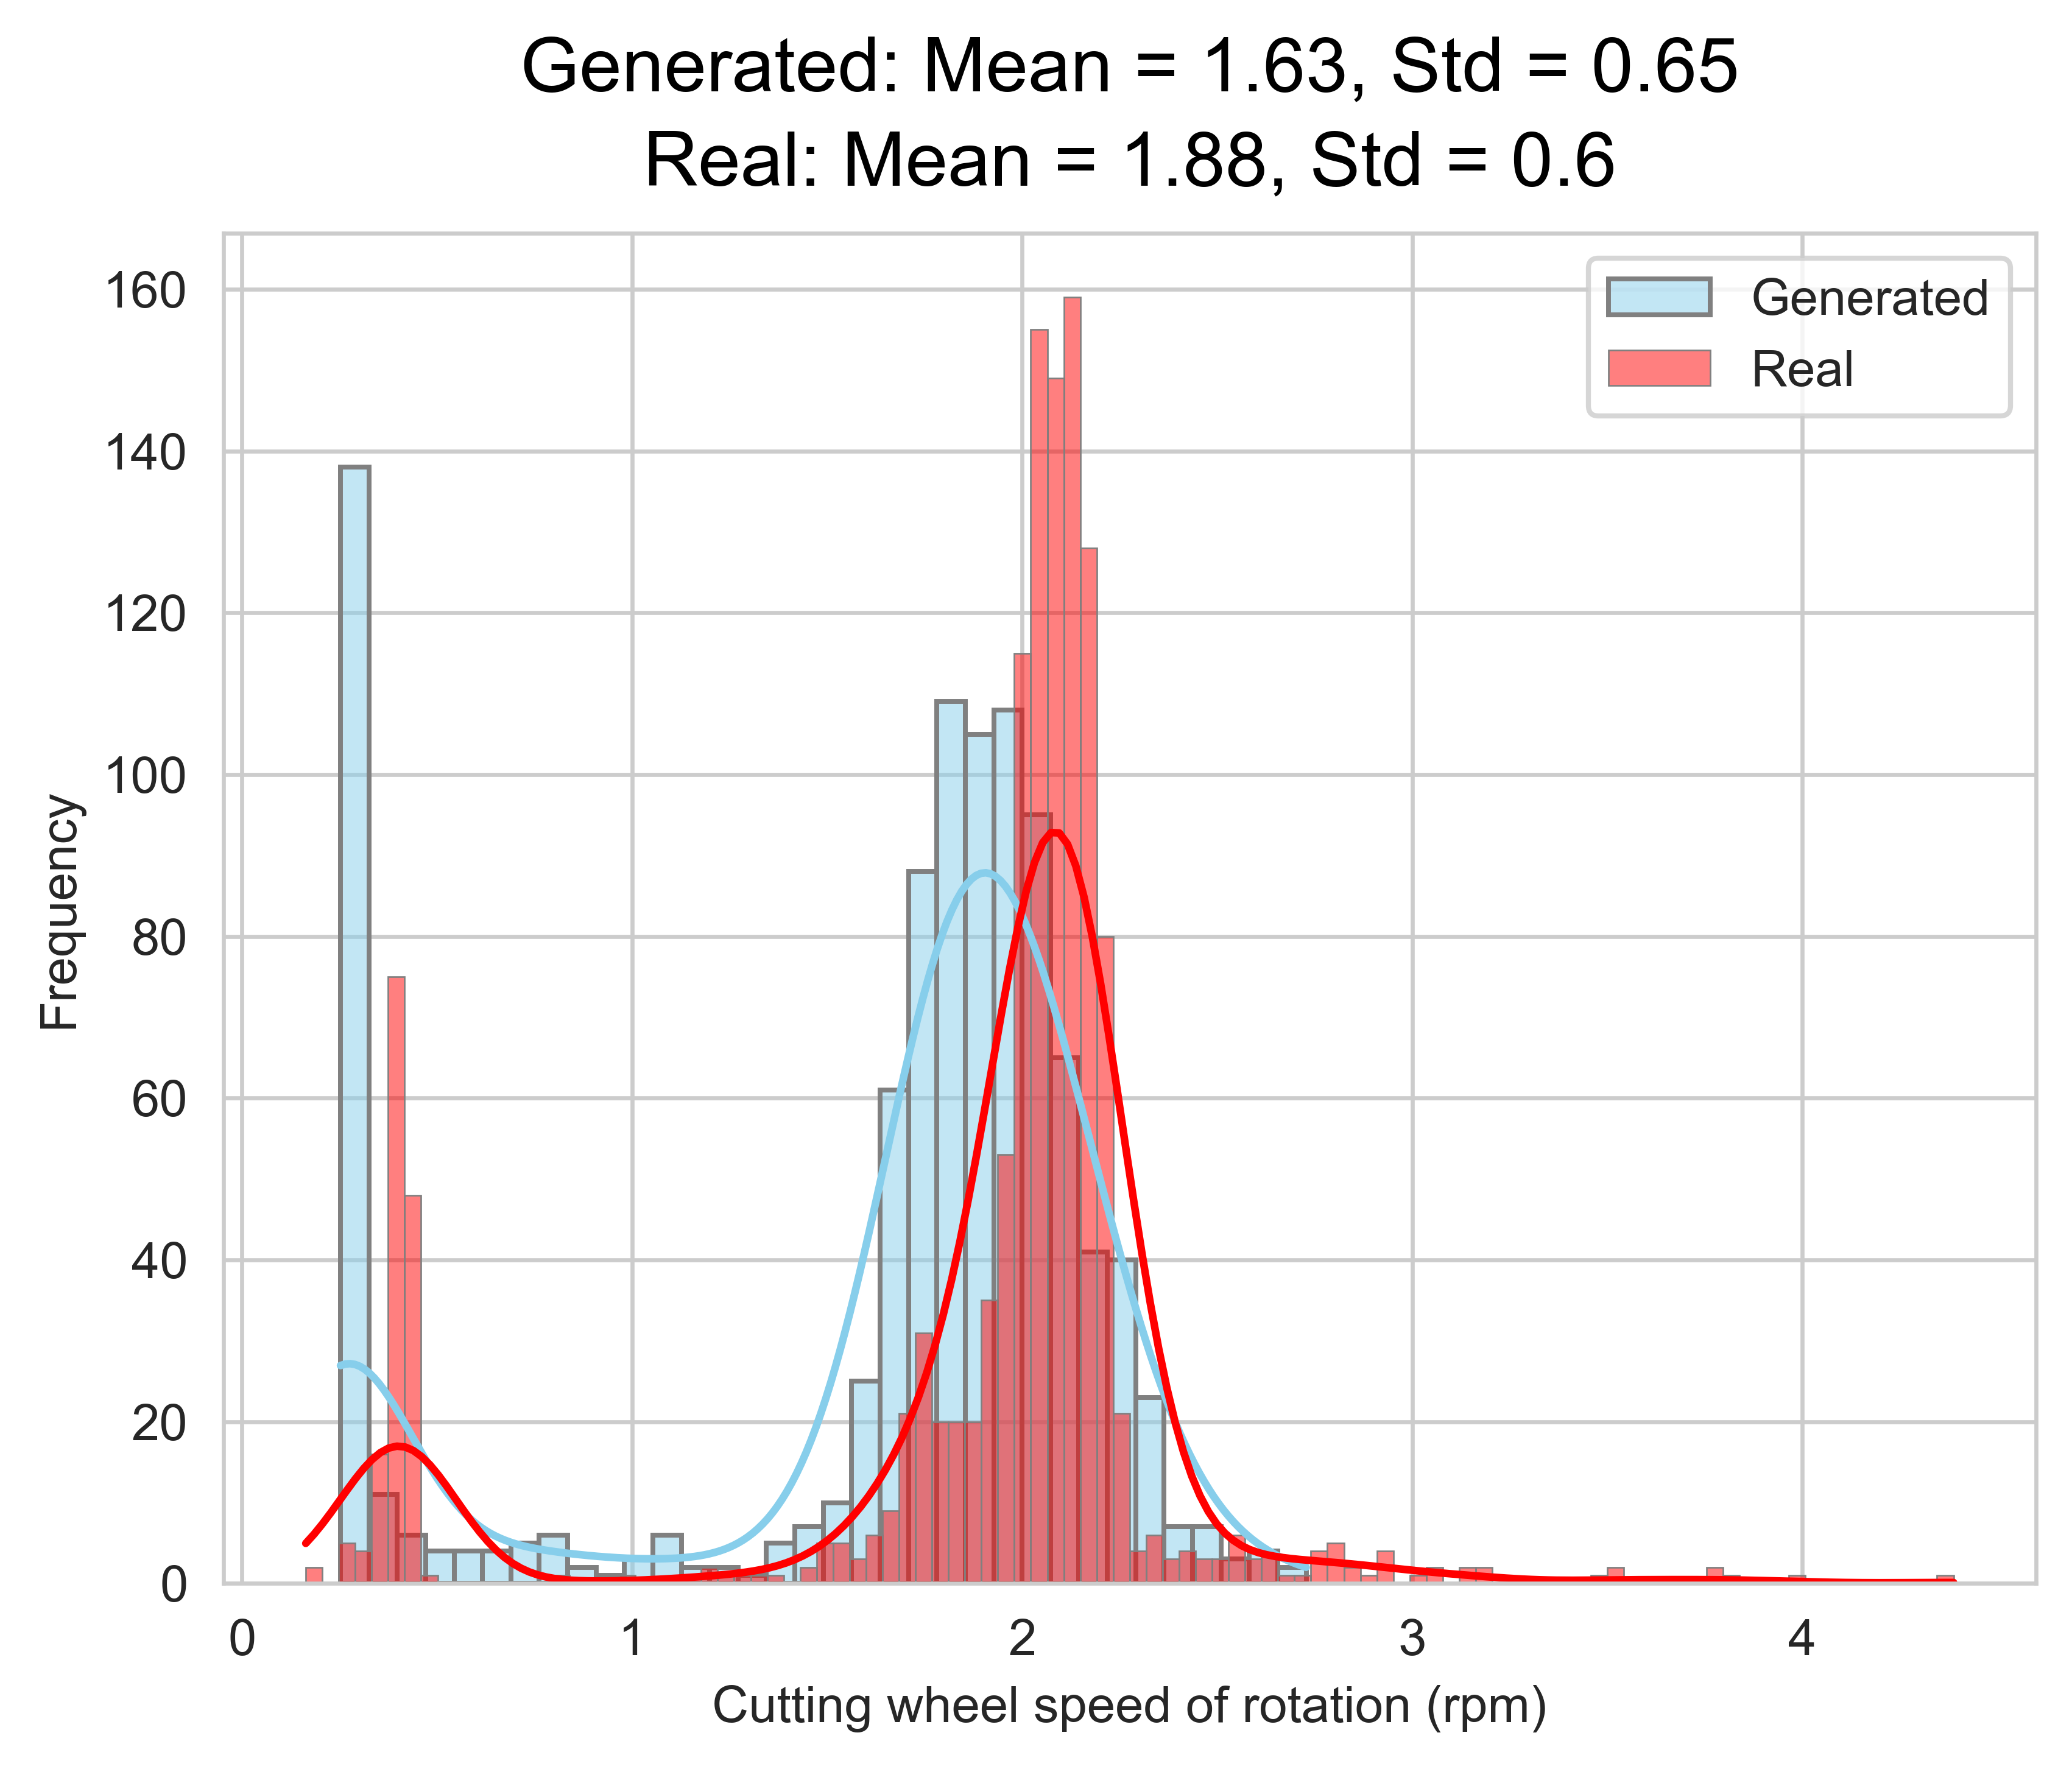

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

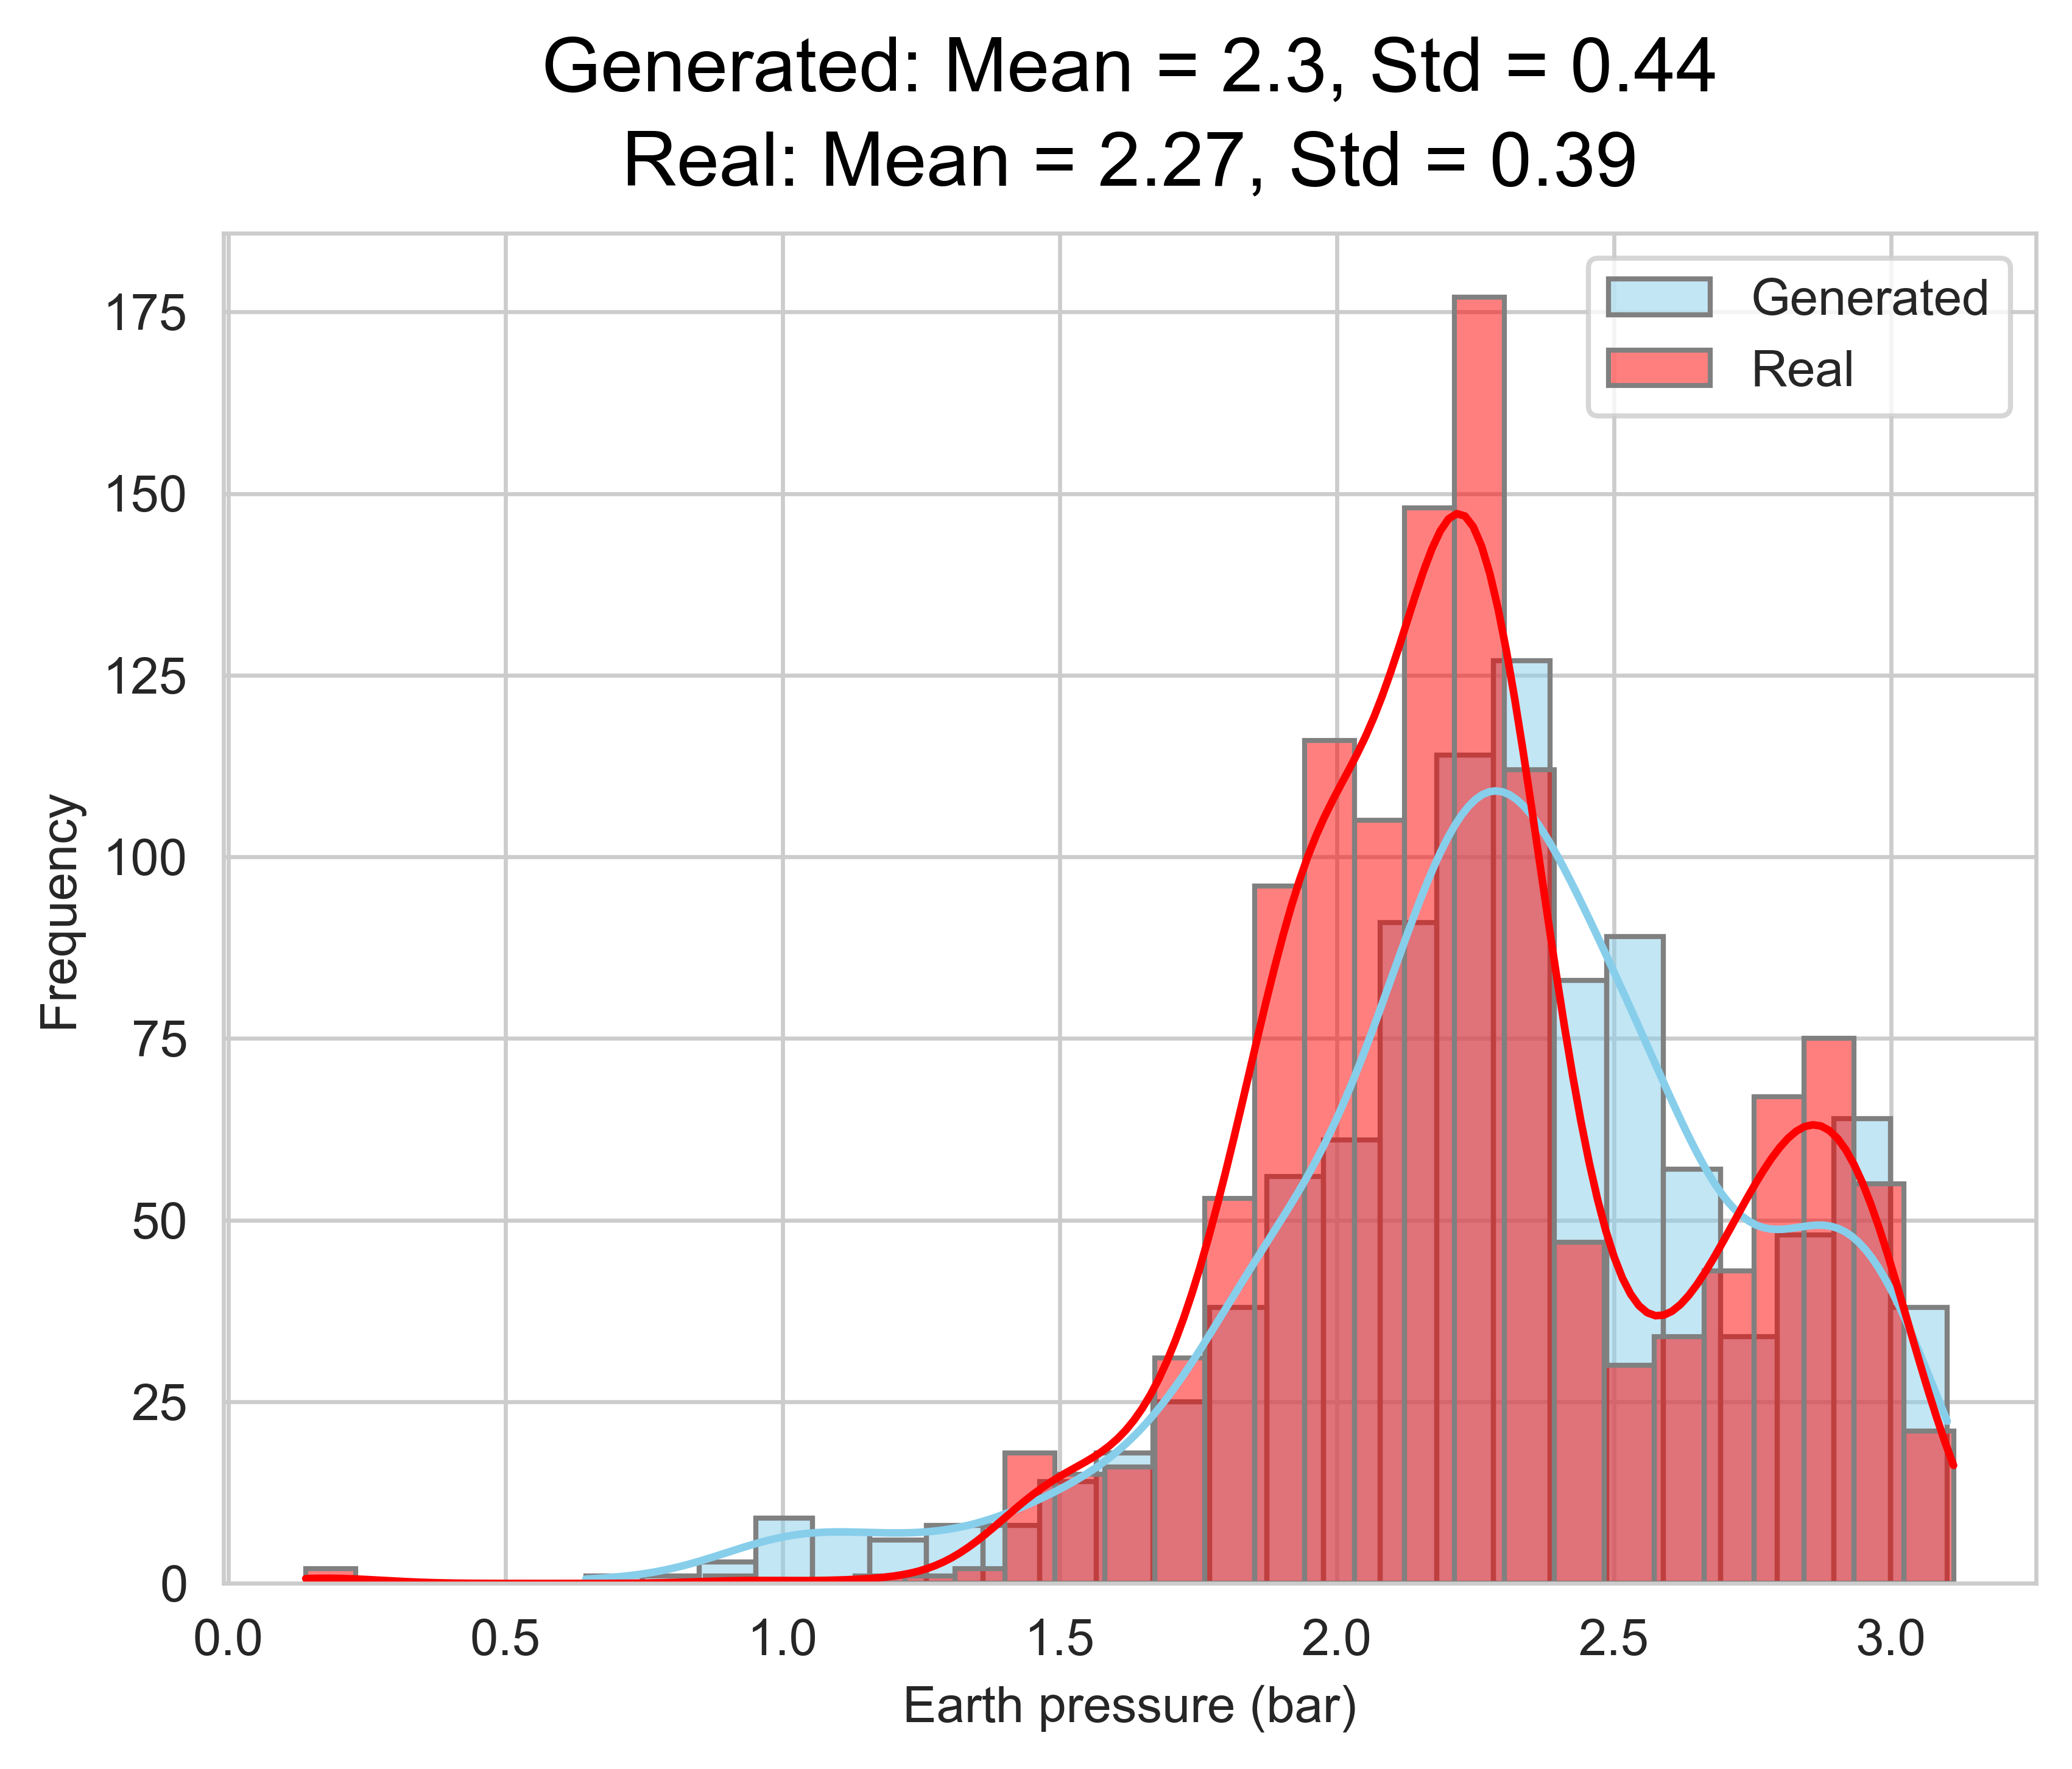

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

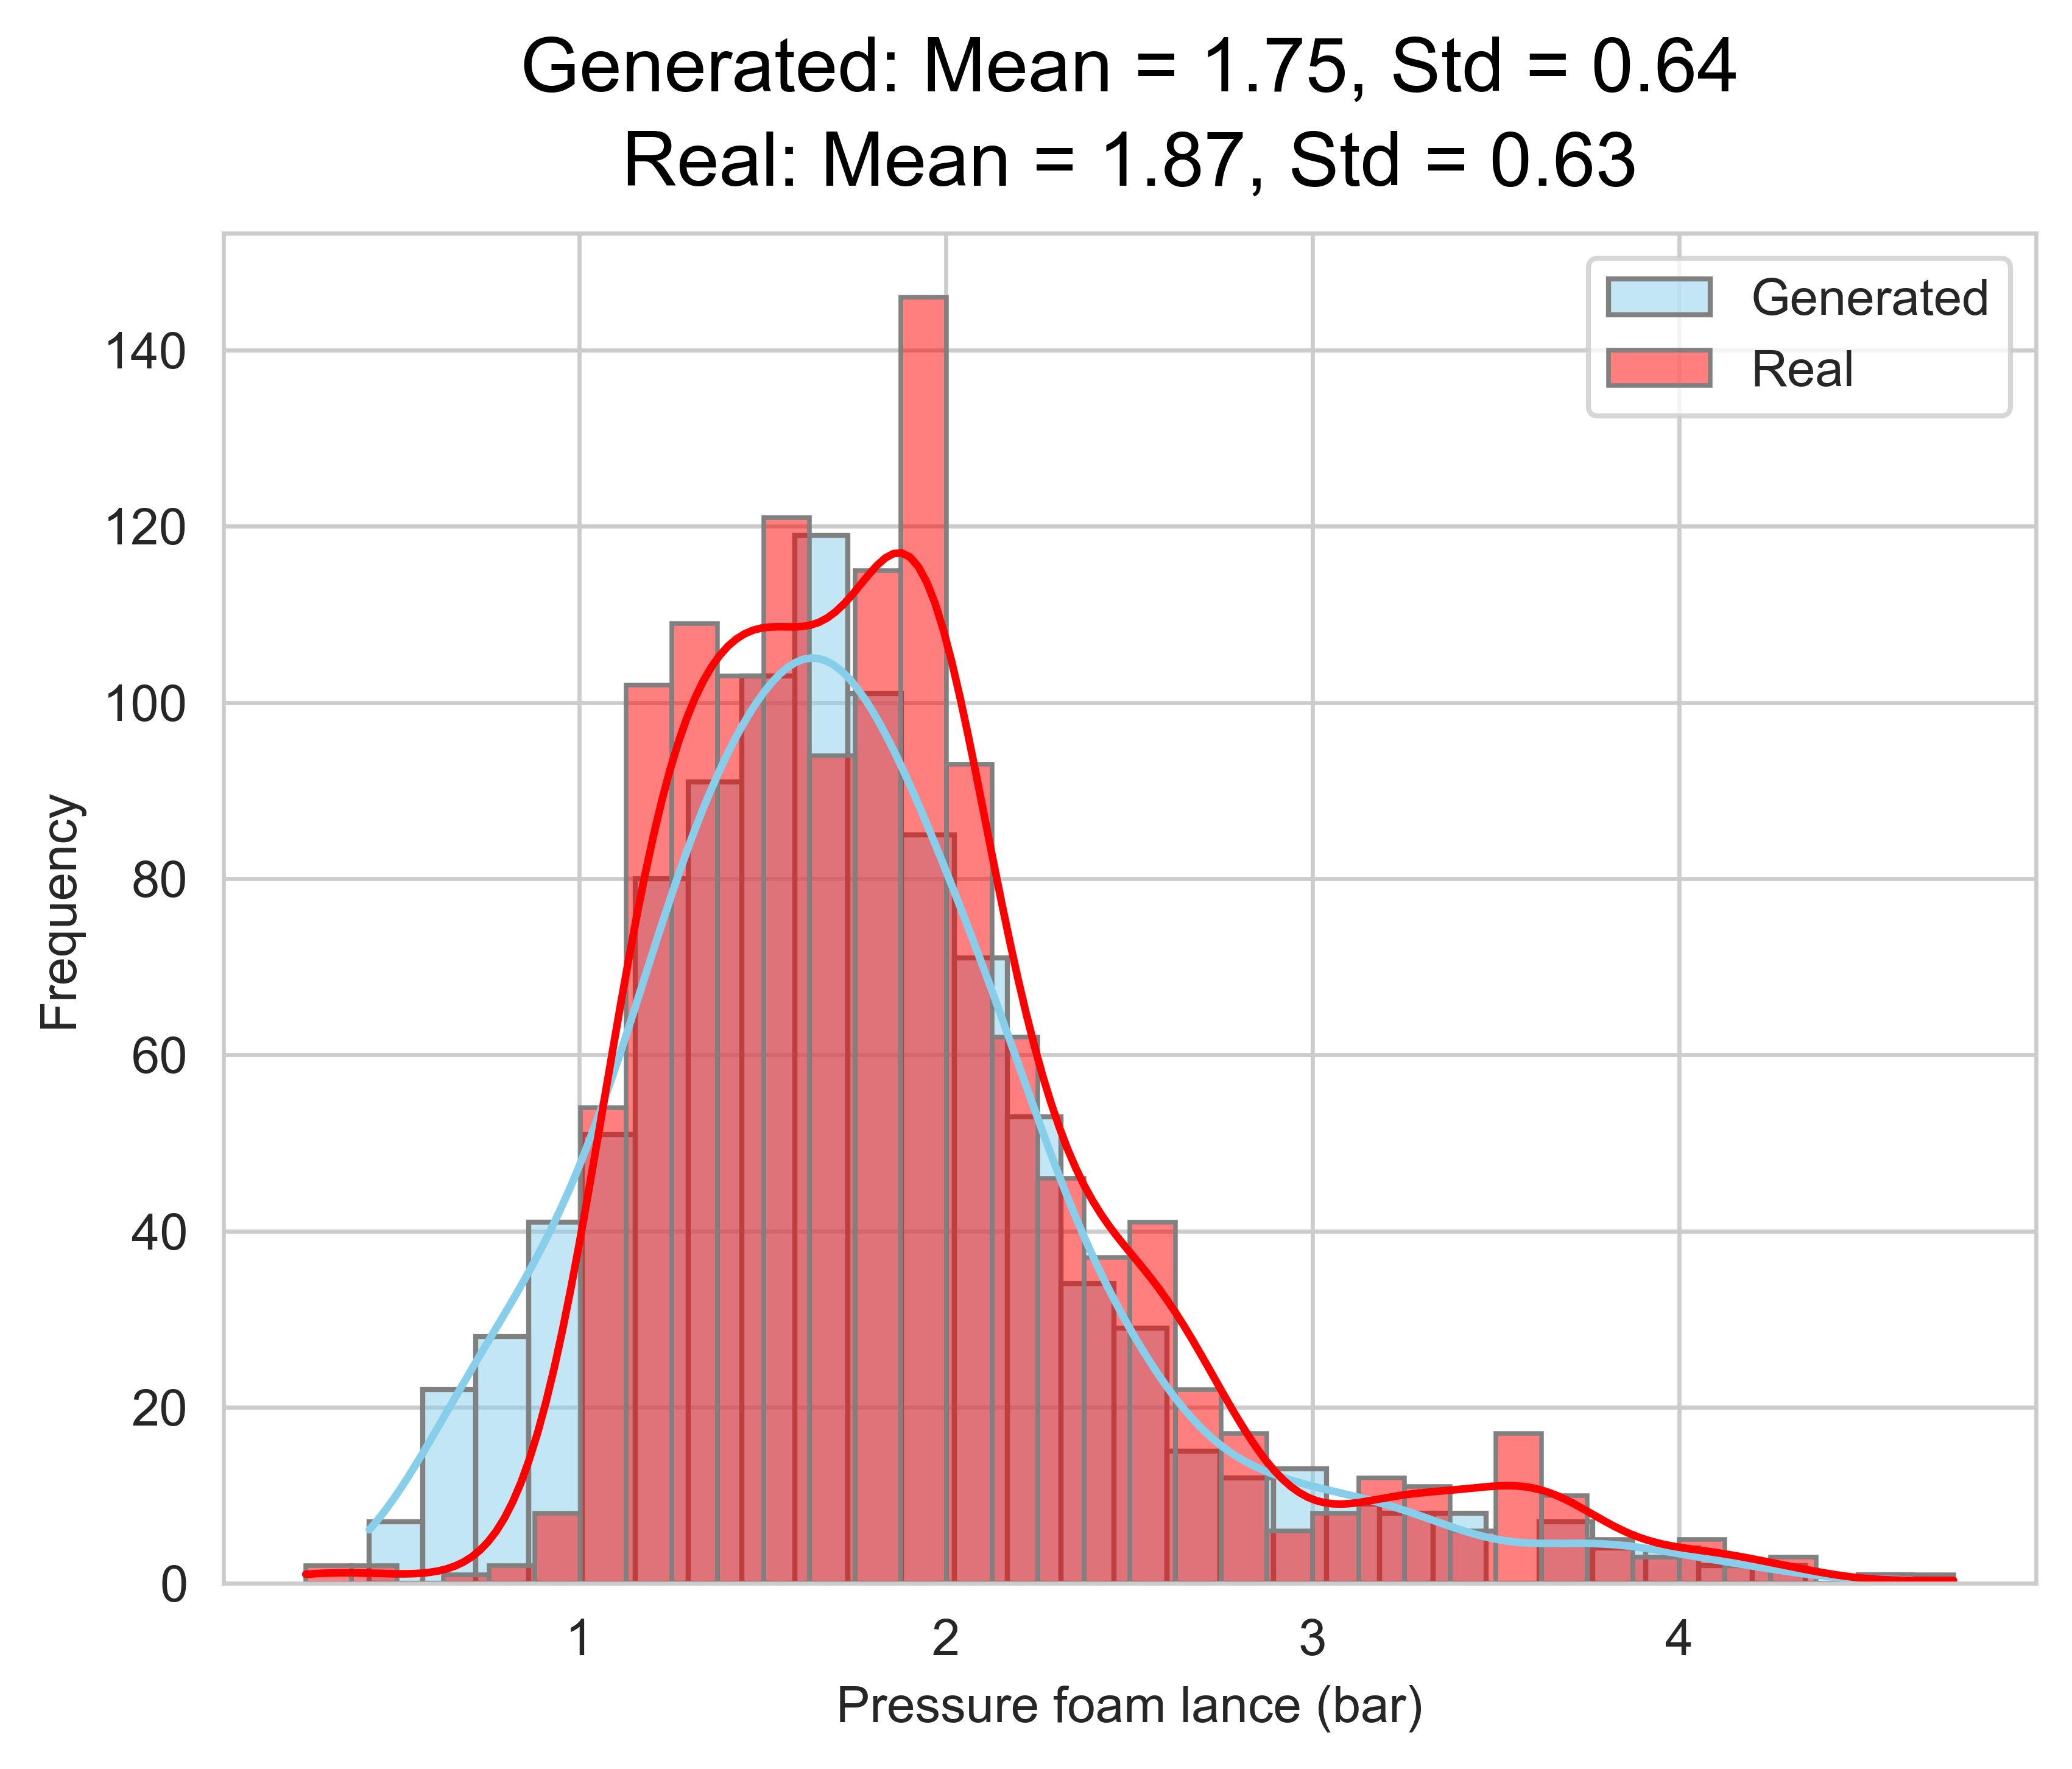

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

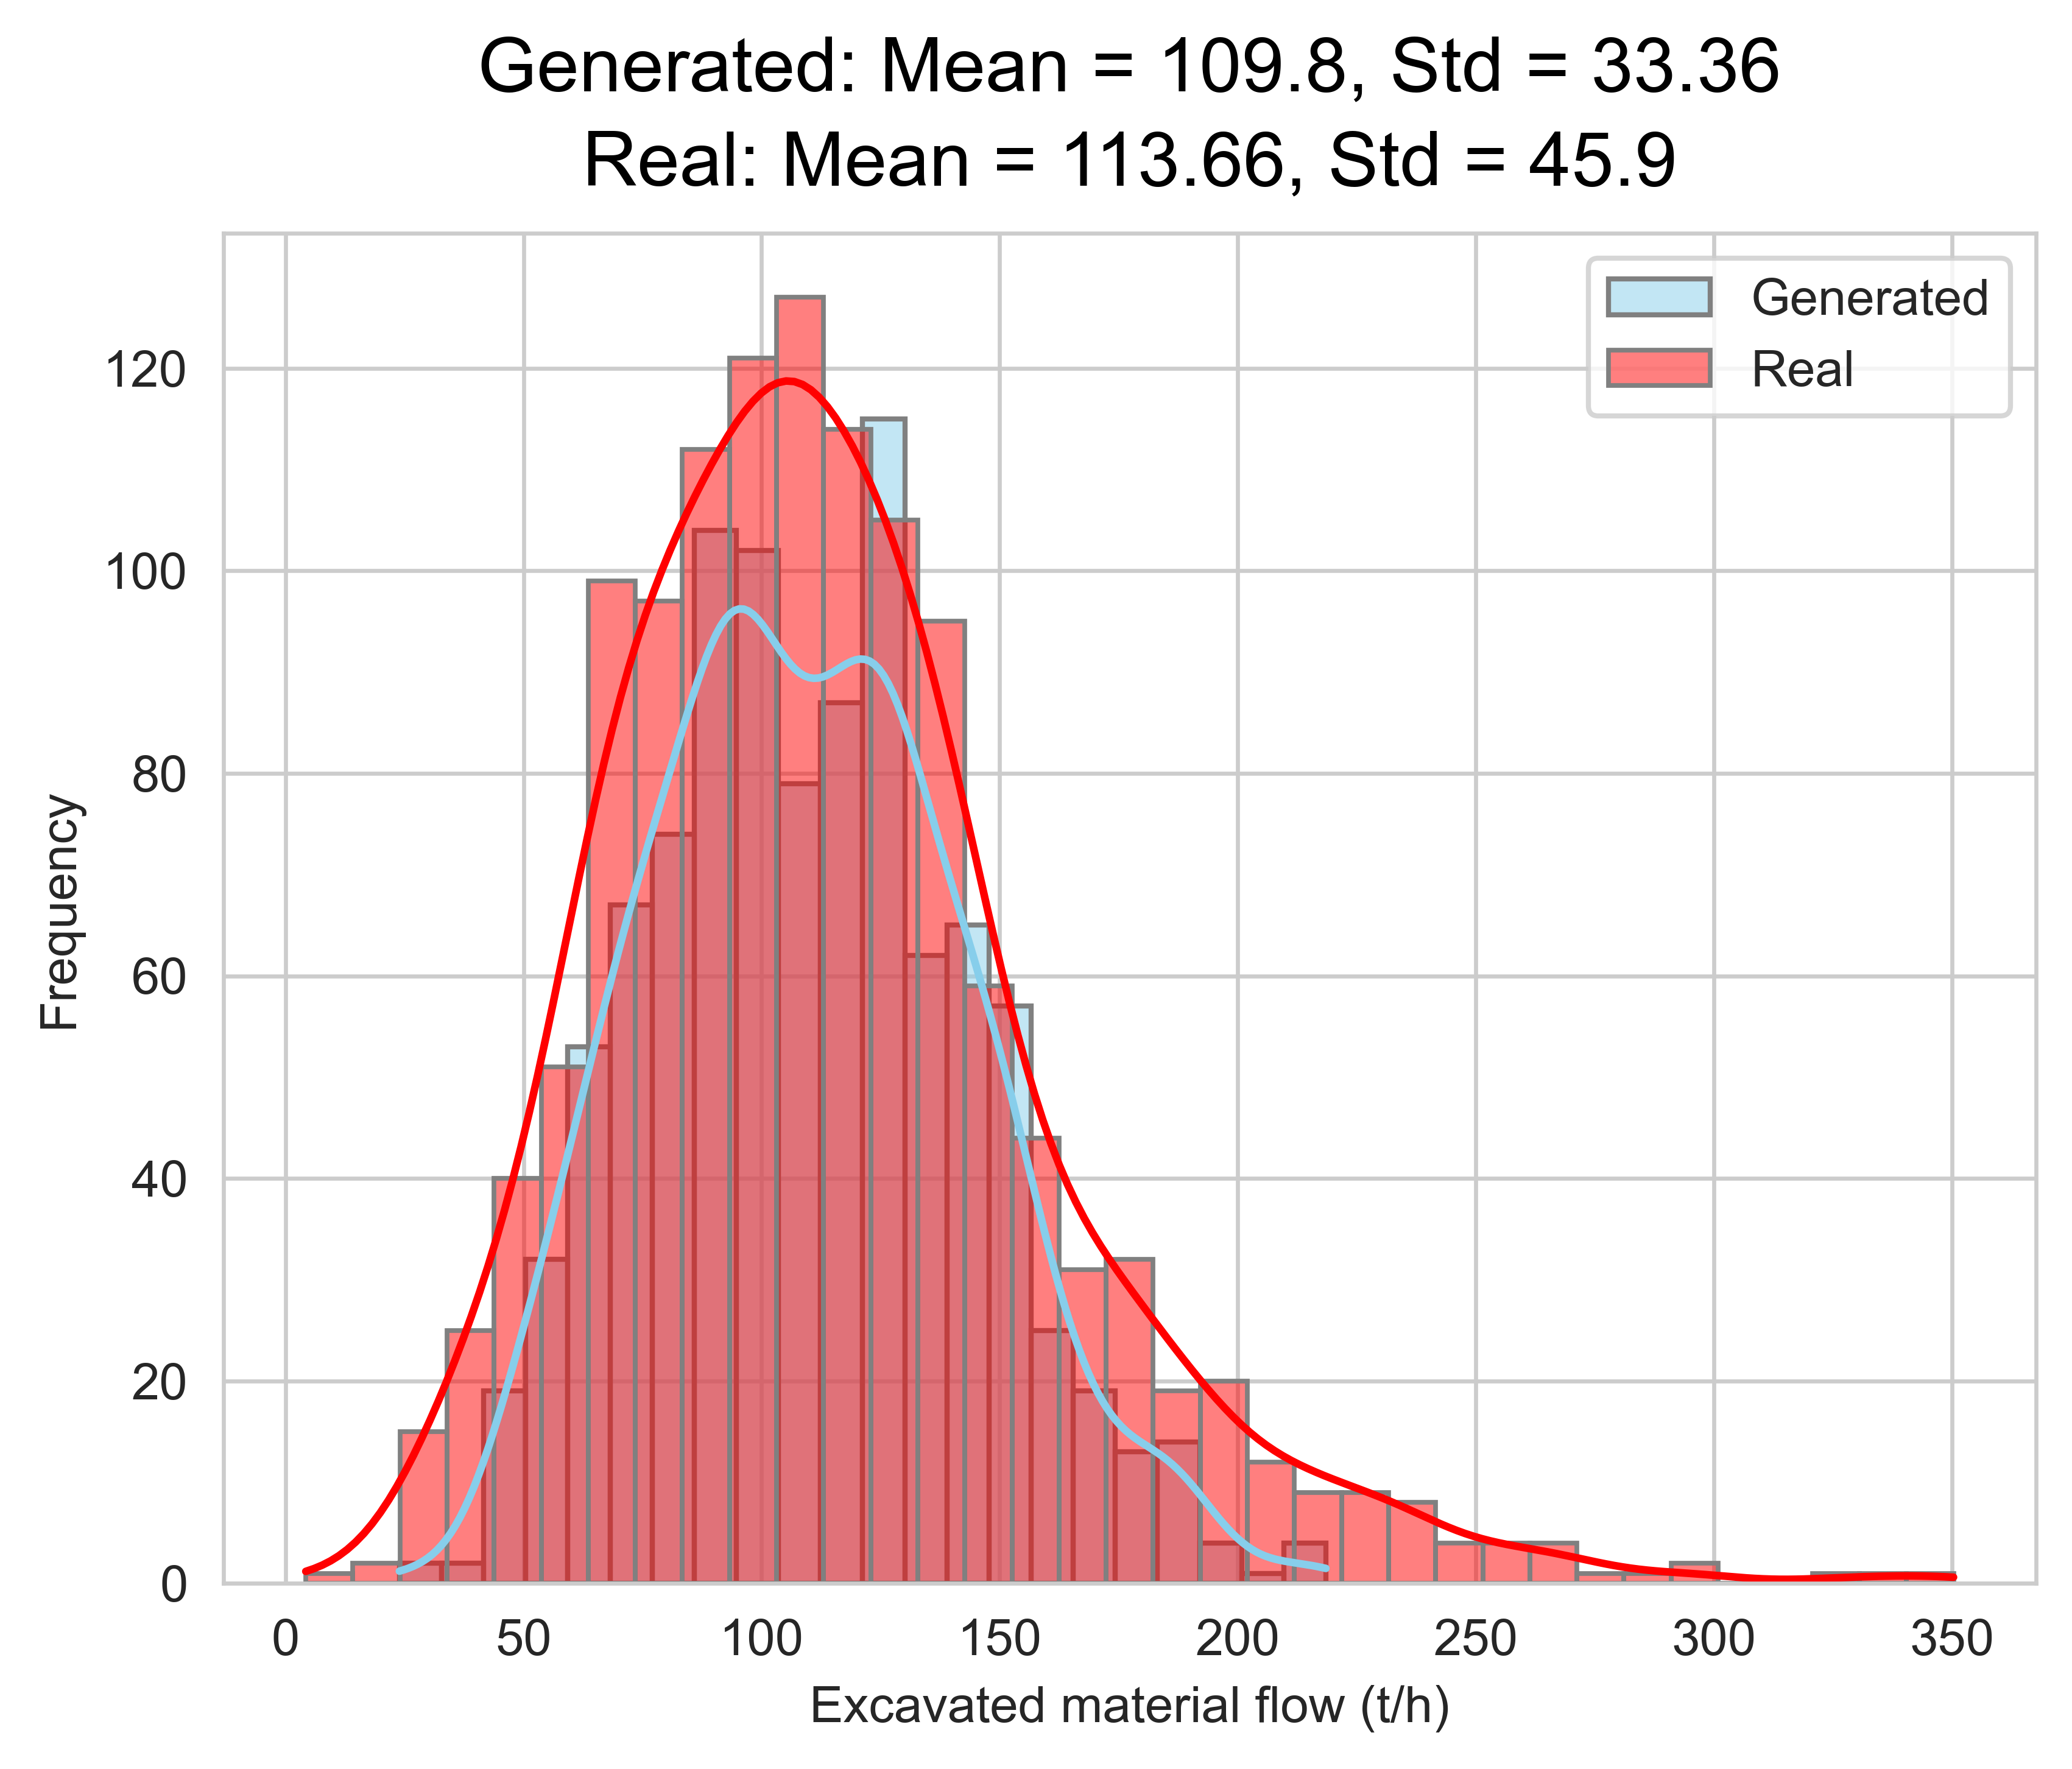

c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Apps\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

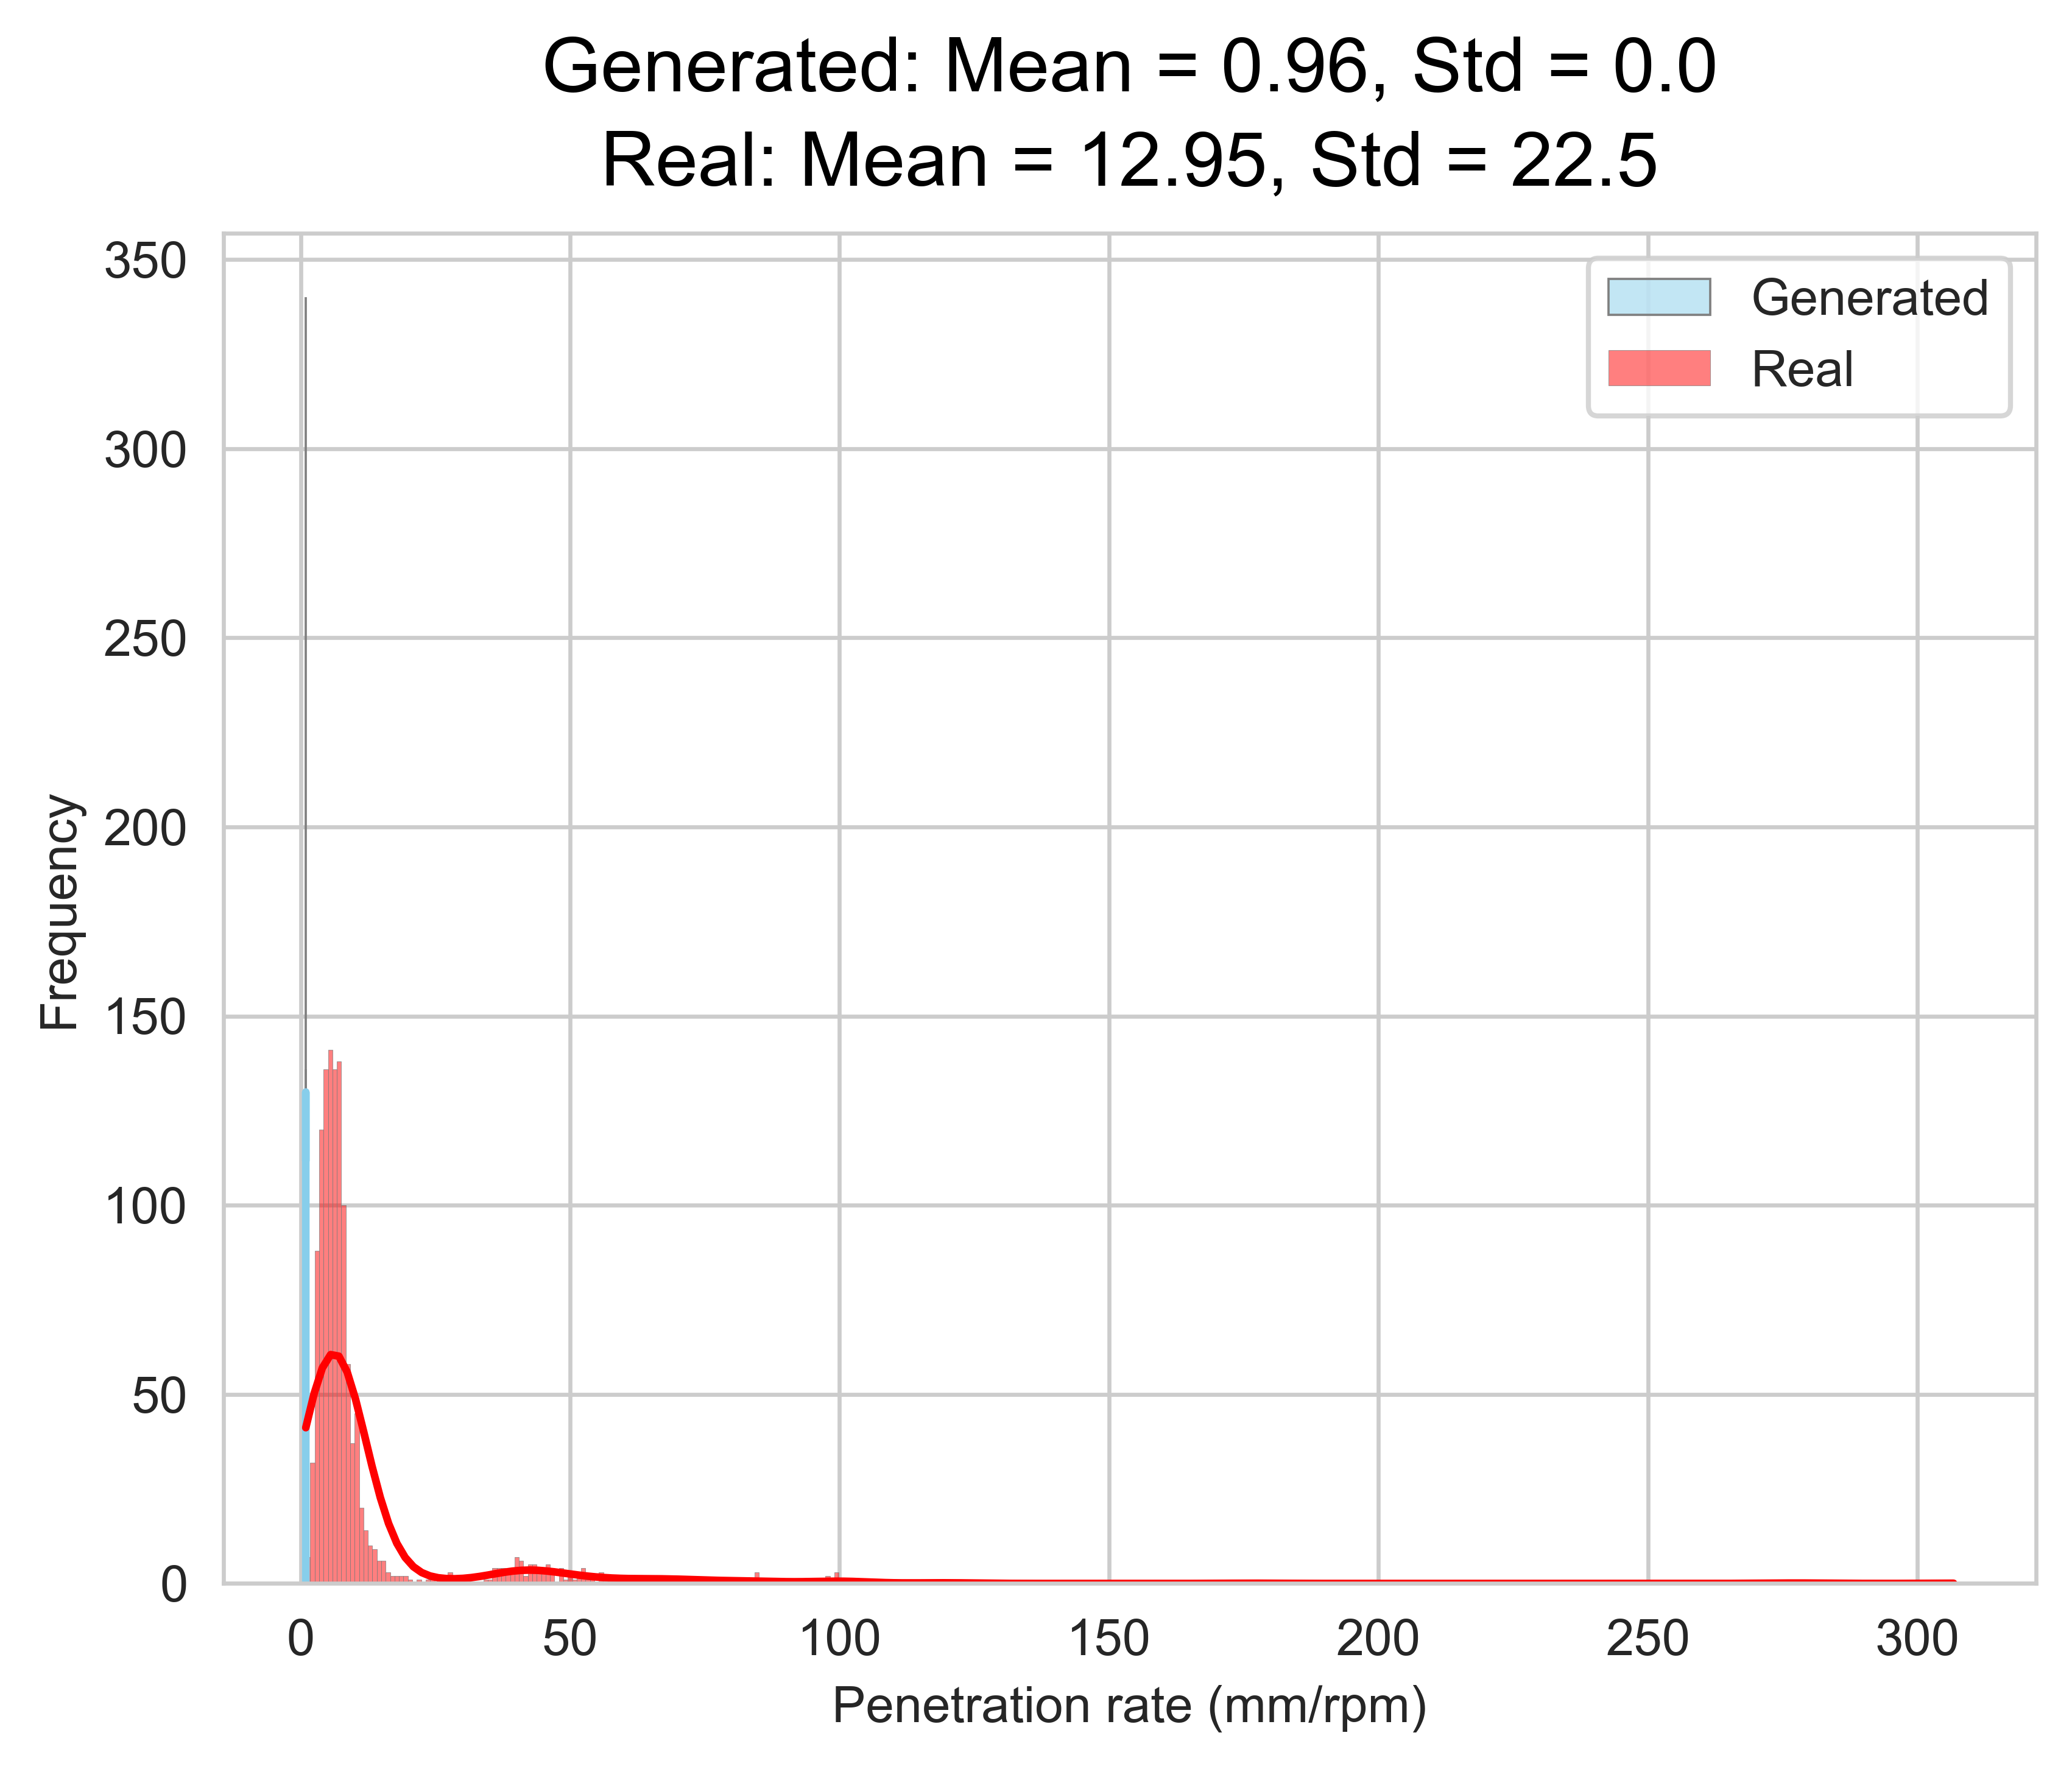

In [36]:
sns.set_style("whitegrid")
for i in range(0,9):
    fig, ax = plt.subplots(dpi=600)
    sns.histplot(x=generated.iloc[:,i], label="Generated", kde=True, color="skyblue", edgecolor='grey')
    sns.histplot(x=real.iloc[:,i], label="Real", kde=True, color="red", edgecolor='grey')
    # Anotate mean, std, percentile
    mu1 = generated.iloc[:,i].mean()
    sigma1 = generated.iloc[:,i].std()
    mu2 = real.iloc[:,i].mean()
    sigma2 = real.iloc[:,i].std()

    textstr1 = 'Generated: ' + 'Mean = ' + str(round(mu1,2))  + ', Std = ' + str(round(sigma1,2))
    textstr2 = 'Real: ' + 'Mean = ' + str(round(mu2,2))  + ', Std = ' + str(round(sigma2,2))

    pylab.text(0.5, 1.05, textstr2, fontsize=15, color="black", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    pylab.text(0.5, 1.12, textstr1, fontsize=15, color="black", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.legend()
    plt.ylabel("Frequency")
    plt.show()
